# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

In [9]:
from PIL import Image, ImageTk, ImageMath, ImageOps
Image.MAX_IMAGE_PIXELS = 1000000000
import PIL.ImageGrab as ImageGrab
import cv2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from io import StringIO
from csv import writer 
from scipy import integrate
import math
import time as time_lib
import xarray as xr
import subprocess
import json
from prettytable import *
import plotly.express as px
from IPython.display import Image as IPImage

inferno = cm.get_cmap('inferno', 256)

def current_milli_time():
    return round(time_lib.time() * 1000 *1000)

In [2]:
from helper_functions import *

# Planetary influence

## Initial Value: Height
64 pixels per degree Displacement Map <br>
23040 x 11520 tif (1012.6 MB)  float, 64 ppd <br>
[source] https://svs.gsfc.nasa.gov/4720

In [3]:
height_data = np.array(Image.open(".\sources\map\heightmap\ldem_64.tif"))

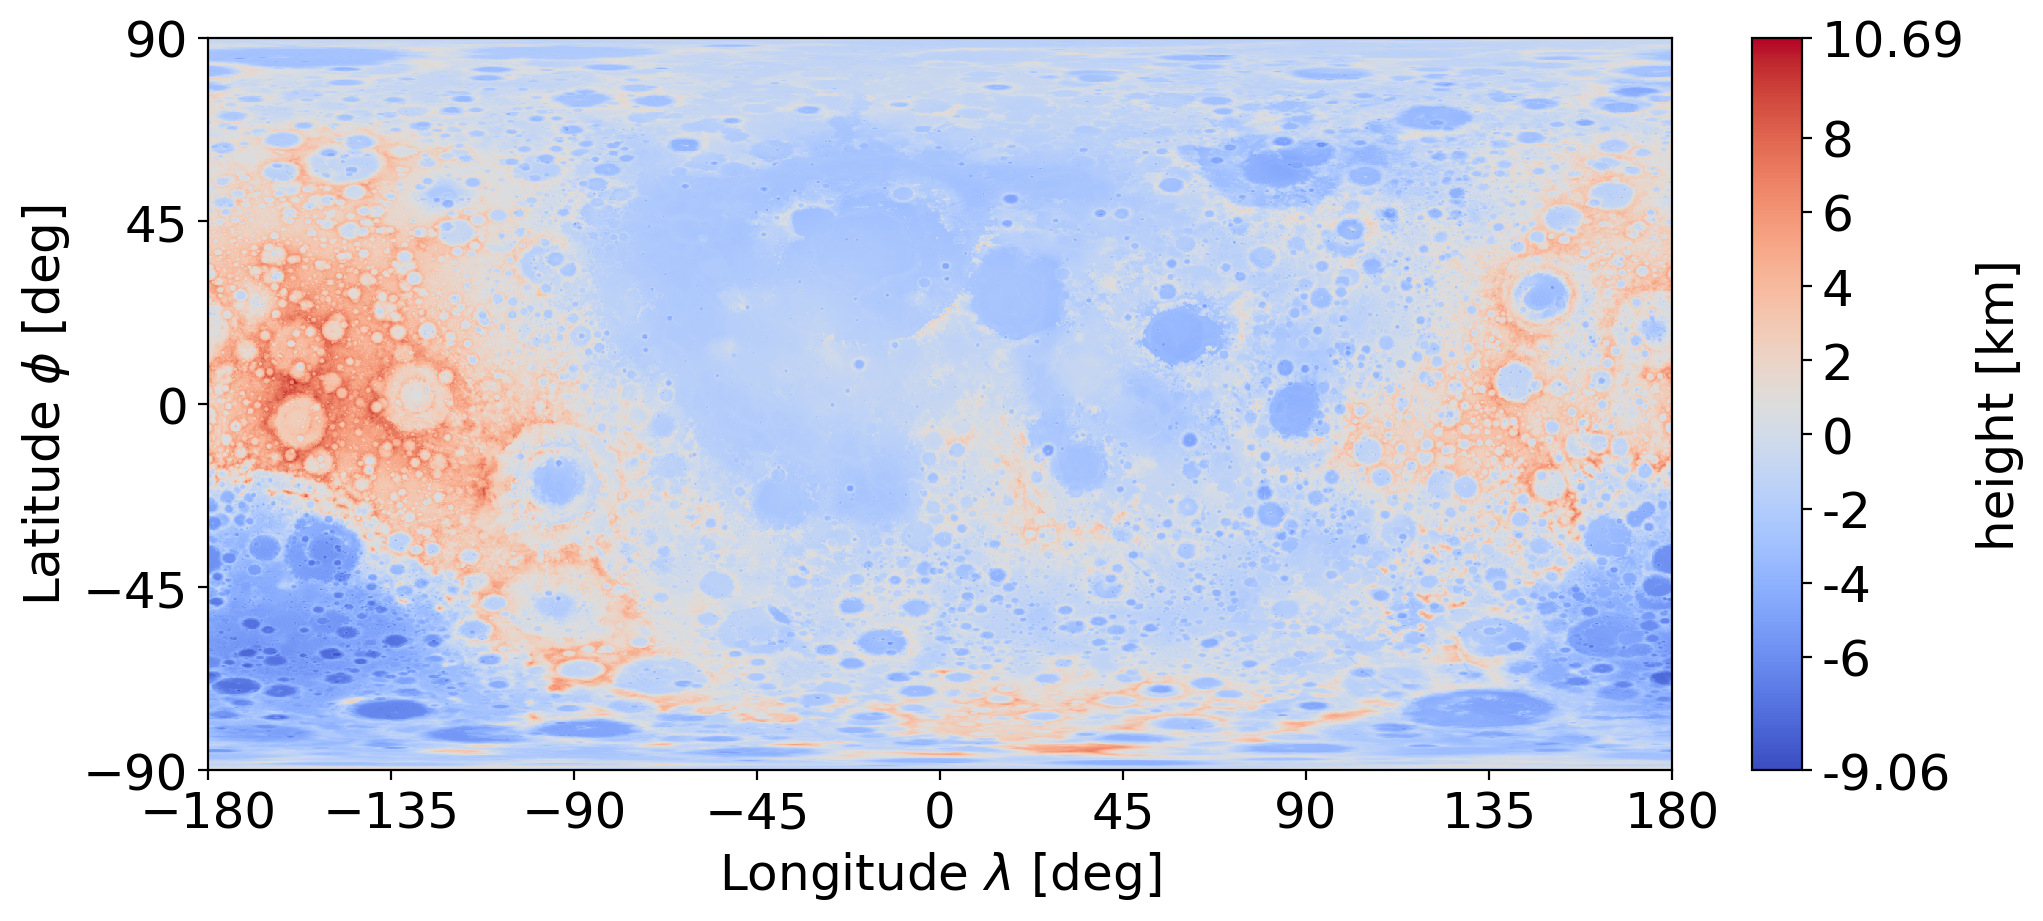

In [6]:
data = cv2.resize(height_data, dsize=(2000,1000), interpolation=cv2.INTER_NEAREST)
plot_map(data,1,'height [km]',tuple((-90,90)),tuple((-180,180)),labelsize=18,cmap='coolwarm',silent=True,center_zero=True,i_steps=[-6,-4,-2,0,2,4,6,8],save="heightmap.pdf")

In [5]:
info(height_data)

float32 (11520, 23040) data range: -9.114500045776367 - 10.757000923156738


In [41]:
r_ref = 1_737_400
r_min = np.min(height_data) + r_ref
r_max = np.max(height_data) + r_ref
r_perc = (1-(r_min/r_max )) * 100

def ascent_into_circular(r,r_orbit):
    g_0_moon = 1.625
    mu_moon = 4.904*(10**12)
    
    v_orbit = np.sqrt(mu_moon/r_orbit)
    v_ascent = np.sqrt(2*g_0_moon*(r-((r**2)/r_orbit)))
    
    dv = np.sqrt(v_orbit**2 + v_ascent**2)
    return dv

h_LLO = 100_000
r_orbit = r_ref + h_LLO

dv_min = ascent_into_circular(r_max,r_orbit)
dv_max = ascent_into_circular(r_min,r_orbit)

dv_perc = (1-(dv_min/dv_max )) * 100

print('r_orbit',r_orbit)
print('r_min:',f'{r_min:0.2f}','r_max',f'{r_max:0.2f}','r_perc',f'{r_perc:0.5f}','%')
print('dv_min:',f'{dv_min:0.3f}','dv_max',f'{dv_max:0.3f}','dv_perc',f'{dv_perc:0.5f}','%')

r_orbit 1837400
r_min: 1737390.89 r_max 1737410.76 r_perc 0.00114 %
dv_min: 1725.187 dv_max 1725.204 dv_perc 0.00097 %


## Initial Value: Ground Speed
Assuming perfect sphere with T = 27.321661 days
<br>
Calculate ground velocity as a fuction from location (Lattitude) over angular speed of the moon.
<br>
ground_speed_map of the shape of height_data

In [43]:
def ground_vel(Lat):
    omega = 2 * np.pi / 2.360592E6 # [s] = (2pi/27.321661 [days])
    v_ground = omega * r_surface(Lat) # [m/s] into direction of turn
    return v_ground

def r_surface(Lat):
    r_axis = np.cos(np.deg2rad(Lat)) * r_moon
    return r_axis

In [56]:
dv_min = ground_vel(90)
dv_max = ground_vel(0)
dv_ref = ascent_into_circular(r_ref,r_orbit)
dv_perc = (dv_max/dv_ref ) * 100
print('dv_ref',f'{dv_ref:0.3f}')
print('dv_min:',f'{dv_min:0.3f}','dv_max',f'{dv_max:0.3f}','dv_perc',f'{dv_perc:0.5f}','%')

dv_ref 1725.196
dv_min: 0.000 dv_max 4.624 dv_perc 0.26805 %


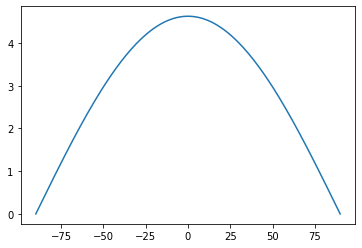

In [48]:
test_Lat = np.linspace(-90,90,180)
test_y = ground_vel(test_Lat)
plt.plot(test_Lat,test_y)
plt.show()

In [6]:
# Create a Map with the shape of height_data.shape
Lat_steps_n = height_data.shape[0]
ground_speed_Lat_vec = np.zeros(Lat_steps_n)
for i in range(Lat_steps_n):
    Lat = 90 - i * 180/Lat_steps_n - 0.5* 180/Lat_steps_n
    ground_speed_Lat_vec[i] = ground_vel(Lat)
ground_speed_data = np.transpose(ground_speed_Lat_vec* np.transpose(np.array([[1]*height_data.shape[1]])))

In [7]:
print(ground_speed_data)

[[0.00063056 0.00063056 0.00063056 ... 0.00063056 0.00063056 0.00063056]
 [0.00189168 0.00189168 0.00189168 ... 0.00189168 0.00189168 0.00189168]
 [0.0031528  0.0031528  0.0031528  ... 0.0031528  0.0031528  0.0031528 ]
 ...
 [0.0031528  0.0031528  0.0031528  ... 0.0031528  0.0031528  0.0031528 ]
 [0.00189168 0.00189168 0.00189168 ... 0.00189168 0.00189168 0.00189168]
 [0.00063056 0.00063056 0.00063056 ... 0.00063056 0.00063056 0.00063056]]


In [ ]:
plot_map(ground_speed_data,1,'velocity [m/s]',tuple((-90,90)),tuple((-180,180)),labelsize=18,cmap='Blues',i_steps=[1,2,3,4],save="ground_speed.png")

# $\Delta V$ estimation

## Source File
extracted .png file from IAC 18 publication pdf

https://keldysh.ru/microsatellites/IAC_18_Trofimov_paper.pdf

In [ ]:
display(IPImage(filename='maps/preparation/NRHO/original.png',width=600))

Source image is from Matlab Jet colormap

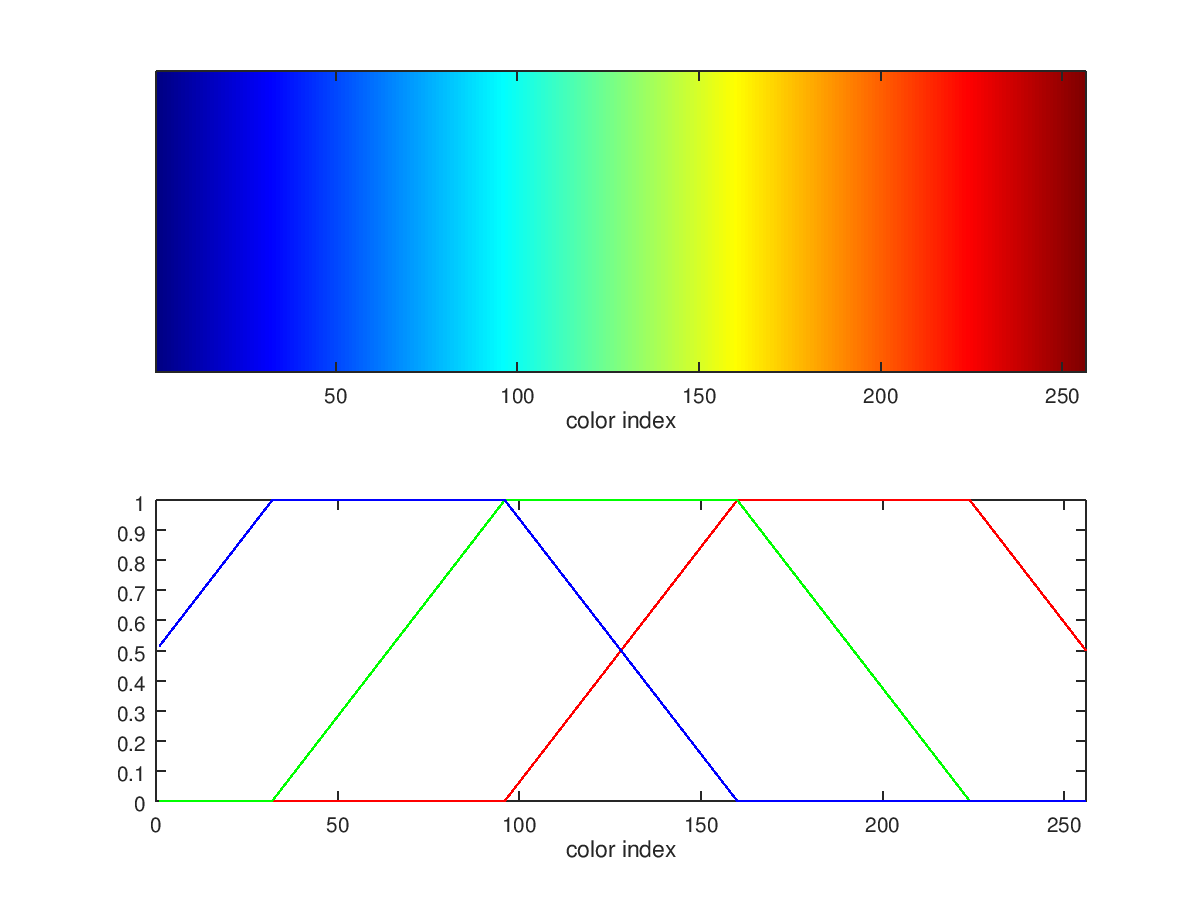

https://octave.sourceforge.io/octave/function/jet.html

In [4]:
# handcrafting all colors (BGR) from jet together in full 8-bit
# (matplotlib jet is slightly different)
# create mapping to dv values

jet_colormap_colors = []
mapping = {}

# 2.4 - 2.6
for i in np.arange(128,256,1):
    pixel = [i,0,0] 
    jet_colormap_colors.append(pixel)
    mapping[str(pixel)] = 0

# 2.6 - 2.8
for i in np.arange(0,256,1):
    pixel = [255,i,0] 
    jet_colormap_colors.append(pixel)
    mapping[str(pixel)] = 0

# 2.8 - 3.0
for i in np.arange(0,256,1):
    pixel = [255-i,255,i]
    jet_colormap_colors.append(pixel)
    mapping[str(pixel)] = 0

# 3.0 - 3.2
#for i in np.arange(0,256,1):
#    pixel = [0,255-i,255]
#    jet_colormap_colors.append(pixel)
#    mapping[str(pixel)] = None


# known values
mapping[str([255,80,0]   )] = 2600 # [m/s]
mapping[str([207,255,48] )] = 2800 # [m/s]

# from 2600 to 2800 number of steps
intermediates = (255-80) + (48)
step = (2800-2600) / intermediates

# compute first entry '[128, 0, 0]'
first_value = 2600 - ( (80+255-128)* step)

for i , val in enumerate(mapping):
    mapping[str(val)] = round(first_value + step*i,2)

# add zero
mapping[str([0,0,0])] = None # used when no value

print(jet_colormap_colors[0:5],' ... ',jet_colormap_colors[-5:])
mapping

[[128, 0, 0], [129, 0, 0], [130, 0, 0], [131, 0, 0], [132, 0, 0]]  ...  [[4, 255, 251], [3, 255, 252], [2, 255, 253], [1, 255, 254], [0, 255, 255]]


{'[128, 0, 0]': 2414.35,
 '[129, 0, 0]': 2415.25,
 '[130, 0, 0]': 2416.14,
 '[131, 0, 0]': 2417.04,
 '[132, 0, 0]': 2417.94,
 '[133, 0, 0]': 2418.83,
 '[134, 0, 0]': 2419.73,
 '[135, 0, 0]': 2420.63,
 '[136, 0, 0]': 2421.52,
 '[137, 0, 0]': 2422.42,
 '[138, 0, 0]': 2423.32,
 '[139, 0, 0]': 2424.22,
 '[140, 0, 0]': 2425.11,
 '[141, 0, 0]': 2426.01,
 '[142, 0, 0]': 2426.91,
 '[143, 0, 0]': 2427.8,
 '[144, 0, 0]': 2428.7,
 '[145, 0, 0]': 2429.6,
 '[146, 0, 0]': 2430.49,
 '[147, 0, 0]': 2431.39,
 '[148, 0, 0]': 2432.29,
 '[149, 0, 0]': 2433.18,
 '[150, 0, 0]': 2434.08,
 '[151, 0, 0]': 2434.98,
 '[152, 0, 0]': 2435.87,
 '[153, 0, 0]': 2436.77,
 '[154, 0, 0]': 2437.67,
 '[155, 0, 0]': 2438.57,
 '[156, 0, 0]': 2439.46,
 '[157, 0, 0]': 2440.36,
 '[158, 0, 0]': 2441.26,
 '[159, 0, 0]': 2442.15,
 '[160, 0, 0]': 2443.05,
 '[161, 0, 0]': 2443.95,
 '[162, 0, 0]': 2444.84,
 '[163, 0, 0]': 2445.74,
 '[164, 0, 0]': 2446.64,
 '[165, 0, 0]': 2447.53,
 '[166, 0, 0]': 2448.43,
 '[167, 0, 0]': 2449.33,
 '[

## crop canvas from orginal image
done in picture editing software - [Paint.NET](https://www.getpaint.net/)

In [26]:
# maps/preparation/NRHO/canvas.png

## transfer only jet colormap colors into canvas_edit

In [5]:
jet_colormap_image  = cv2.imread('maps/preparation/NRHO/canvas.png')

jet_color_mask = np.zeros(jet_colormap_image.shape[:2], dtype=np.uint8)

for color in tqdm(jet_colormap_colors):
    lower_bound = np.array(color)
    upper_bound = np.array(color)
    jet_color_mask += cv2.inRange(jet_colormap_image, lower_bound, upper_bound)

result_image = cv2.bitwise_and(jet_colormap_image, jet_colormap_image, mask=jet_color_mask)

rgba_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2BGRA)
black_pixels = np.all(rgba_image[:, :, :3] == [0, 0, 0], axis=-1)
rgba_image[black_pixels, 3] = 0  # Set alpha channel to 0 for black pixels

cv2.imwrite('maps/preparation/NRHO/canvas_edit.png', rgba_image)

  0%|          | 0/640 [00:00<?, ?it/s]

True

In [ ]:
display(Image(filename='maps/preparation/NRHO/canvas_edit.png',width=600))

## Tile the cavas_edit and take the minimum for the whole tile

In [6]:
def find_minimum_pixel_by_jet_colormap(image):
    rows, cols, _ = image.shape

    min_pixel = None
    min_jet_index = float('inf')

    pixels_1d = image.reshape(-1, 3)
    unique_pixels = np.unique(pixels_1d, axis=0)

    for i in unique_pixels:
            blue_value = i[0]
            green_value = i[1]
            red_value = i[2]

            if blue_value == 0 and green_value == 0 and red_value == 0:
                pass
            else:
                jet_index = blue_value + 256 * green_value + 256 * 256 * red_value
    
                if jet_index < min_jet_index:
                    min_jet_index = jet_index
                    min_pixel = i

    if min_pixel is None:
        min_pixel = [0,0,0]
    return min_pixel

In [24]:
img = cv2.imread('maps/preparation/NRHO/canvas_edit.png') # [0] Blue [1] Green [2] Red
print(img.shape)

# original map had non equal axis scaling
# 6 x 30° Lat height
# 8 x 45° Lon width
# 3729 x 2721 resolution


# square tiles in degrees
tile_deg_res = 20 # [deg]

# create tile height
#tile_height = 30/res_div # deg
divider_h = 180/tile_deg_res
tile_height_px = int(img.shape[0]/divider_h) # px

# create tile width
#tile_width = 45/res_div # deg
divider_w = 360/tile_deg_res
tile_width_px = int(img.shape[1]/divider_w) # px

Lat = int(img.shape[0] / tile_height_px)
Lon = int(img.shape[1] / tile_width_px)

print(Lat,Lon)

# for X-Array result
dv_map_NRHO_raw = np.zeros((Lat,Lon))

for i in tqdm(range(Lat)):
    for j in range(Lon):
        
        begin_height = i * tile_height_px
        end_heigth =  (i+1) * tile_height_px
        begin_width = j * tile_width_px
        end_width = (j+1) * tile_width_px
        
        #print(f"Tile {i} {j} going from [{begin_height} : {end_heigth}] and [{begin_width} : {end_width}]")
        tile_px = img[begin_height:end_heigth,begin_width:end_width]
        #cv2.imwrite(f'maps/preparation/NRHO/tiles/tile_{i}_{j}.png', tile_px)

        min = find_minimum_pixel_by_jet_colormap(tile_px)
        min_to_str = [min[0],min[1],min[2]]
        
        dv_map_NRHO_raw[i,j] =  mapping[str(min_to_str)]
        img[begin_height:end_heigth,begin_width:end_width] = min

rgba_image = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
black_pixels = np.all(rgba_image[:, :, :3] == [0, 0, 0], axis=-1)
rgba_image[black_pixels, 3] = 0  # Set alpha channel to 0 for black pixels

cv2.imwrite('maps/preparation/NRHO/canvas_tiled.png', rgba_image)

(2721, 3729, 3)
9 18


  0%|          | 0/9 [00:00<?, ?it/s]

True

In [ ]:
display(Image(filename='maps/preparation/NRHO/canvas_tiled.png',width=600))

## interpolate missing tile data from neighbor tiles

In [25]:
dv_map_NRHO_raw

array([[2509.42, 2424.22, 2600.9 , 2417.04, 2417.04, 2489.69, 2449.33,
        2414.35, 2526.46, 2426.91, 2414.35, 2414.35, 2416.14, 2415.25,
        2418.83, 2447.53, 2440.36, 2439.46],
       [2477.13, 2514.8 , 2539.91, 2553.36, 2526.46, 2502.24, 2449.33,
        2487.89, 2427.8 , 2415.25, 2414.35, 2417.04, 2417.94, 2423.32,
        2425.11, 2453.81, 2449.33, 2483.41],
       [2521.08, 2610.76, 2553.36, 2553.36, 2526.46, 2554.26, 2540.81,
        2513.  , 2454.71, 2429.6 , 2418.83, 2426.01, 2435.87, 2445.74,
        2452.02, 2465.47, 2530.04, 2528.25],
       [2643.05, 2660.09, 2690.58, 2649.33, 2652.02, 2631.39, 2593.72,
        2574.89, 2516.59, 2460.99, 2452.02, 2452.02, 2460.99, 2492.38,
        2504.93, 2523.77, 2621.52, 2606.28],
       [2727.35, 2798.21, 2782.96, 2761.43, 2740.81, 2730.94, 2674.44,
        2632.29, 2597.31, 2579.37, 2521.97, 2520.18, 2565.92, 2576.68,
        2595.52, 2719.28, 2713.  , 2731.84],
       [2818.83, 2828.7 , 2852.91, 2855.61, 2816.14, 2828.7 , 274

In [30]:
data = dv_map_NRHO_raw

# Iterate through each row and perform interpolation
# assumes high Longitudinal consistency at poles

for row_idx in range(data.shape[0]):
    row = data[row_idx]
    nan_indices = np.isnan(row)
    not_nan_indices = ~nan_indices
    
    if np.any(nan_indices):
        row_interp = np.interp(nan_indices.nonzero()[0], not_nan_indices.nonzero()[0], row[not_nan_indices])
        row[nan_indices] = row_interp

dv_map_NRHO = data

In [31]:
# save into x-Array

Lon = np.arange(-180+tile_deg_res/2, 180,tile_deg_res)
Lat = np.arange(-90+tile_deg_res/2, 90,tile_deg_res)

xA_dv_map_NRHO = xr.DataArray(
    data=dv_map_NRHO,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="DeltaV for direct transfer from Lunar Surface to Lunar Gateway (Southern 9:2 NRHO)",
        var_desc="$\Delta v$",
        units="m/s",
    ),
)

xA_dv_map_NRHO.to_netcdf("maps/dv_map_NRHO.nc")
xA_dv_map_NRHO

<xarray.DataArray (lat: 9, lon: 18)>
array([[2509.42      , 2424.22      , 2600.9       , 2417.04      ,
        2417.04      , 2489.69      , 2449.33      , 2414.35      ,
        2526.46      , 2426.91      , 2414.35      , 2414.35      ,
        2416.14      , 2415.25      , 2418.83      , 2447.53      ,
        2440.36      , 2439.46      ],
       [2477.13      , 2514.8       , 2539.91      , 2553.36      ,
        2526.46      , 2502.24      , 2449.33      , 2487.89      ,
        2427.8       , 2415.25      , 2414.35      , 2417.04      ,
        2417.94      , 2423.32      , 2425.11      , 2453.81      ,
        2449.33      , 2483.41      ],
       [2521.08      , 2610.76      , 2553.36      , 2553.36      ,
        2526.46      , 2554.26      , 2540.81      , 2513.        ,
        2454.71      , 2429.6       , 2418.83      , 2426.01      ,
        2435.87      , 2445.74      , 2452.02      , 2465.47      ,
        2530.04      , 2528.25      ],
       [2643.05      , 2660.09      , 2690.58      , 2649.33      ,
        2652.02      , 2631.39      , 2593.72      , 2574.89      ,
        2516.59      , 2460.99      , 2452.02      , 2452.02      ,
        2460.99      , 2492.38      , 2504.93      , 2523.77      ,
        2621.52      , 2606.28      ],
...
       [2818.83      , 2828.7       , 2852.91      , 2855.61      ,
        2816.14      , 2828.7       , 2748.88      , 2735.43      ,
        2741.7       , 2746.19      , 2618.83      , 2604.48      ,
        2632.29      , 2664.57      , 2684.3       , 2822.42      ,
        2814.35      , 2814.35      ],
       [2881.61      , 2876.23      , 2912.11      , 2958.74      ,
        2902.24      , 2834.08      , 2850.22      , 2841.26      ,
        2830.49      , 2837.67      , 2775.78      , 2730.94      ,
        2735.43      , 2740.81      , 2830.49      , 2864.57      ,
        2884.3       , 2895.96      ],
       [2956.95      , 2977.58      , 2934.53      , 2950.67      ,
        2935.43      , 2904.93      , 2887.        , 2876.23      ,
        2876.23      , 2883.41      , 2845.74      , 2936.32      ,
        2916.59      , 2881.61      , 2881.61      , 2953.36      ,
        2961.43      , 2948.88      ],
       [2973.99      , 2973.99      , 2973.99      , 2981.17      ,
        2971.3       , 2971.3       , 2974.89      , 2976.68      ,
        2974.89      , 2972.2       , 2973.39333333, 2974.58666667,
        2975.78      , 2982.06      , 2982.9575    , 2983.855     ,
        2984.7525    , 2985.65      ]])
Coordinates:
  * lon      (lon) float64 -170.0 -150.0 -130.0 -110.0 ... 130.0 150.0 170.0
  * lat      (lat) float64 -80.0 -60.0 -40.0 -20.0 0.0 20.0 40.0 60.0 80.0
Attributes:
    description:  DeltaV for direct transfer from Lunar Surface to Lunar Gate...
    var_desc:     $\Delta v$
    units:        m/s

In [6]:
# load xArray from file
xA_dv_map_NRHO = xr.open_dataarray("maps/dv_map_NRHO.nc")
dv_map_NRHO = xA_dv_map_NRHO.data

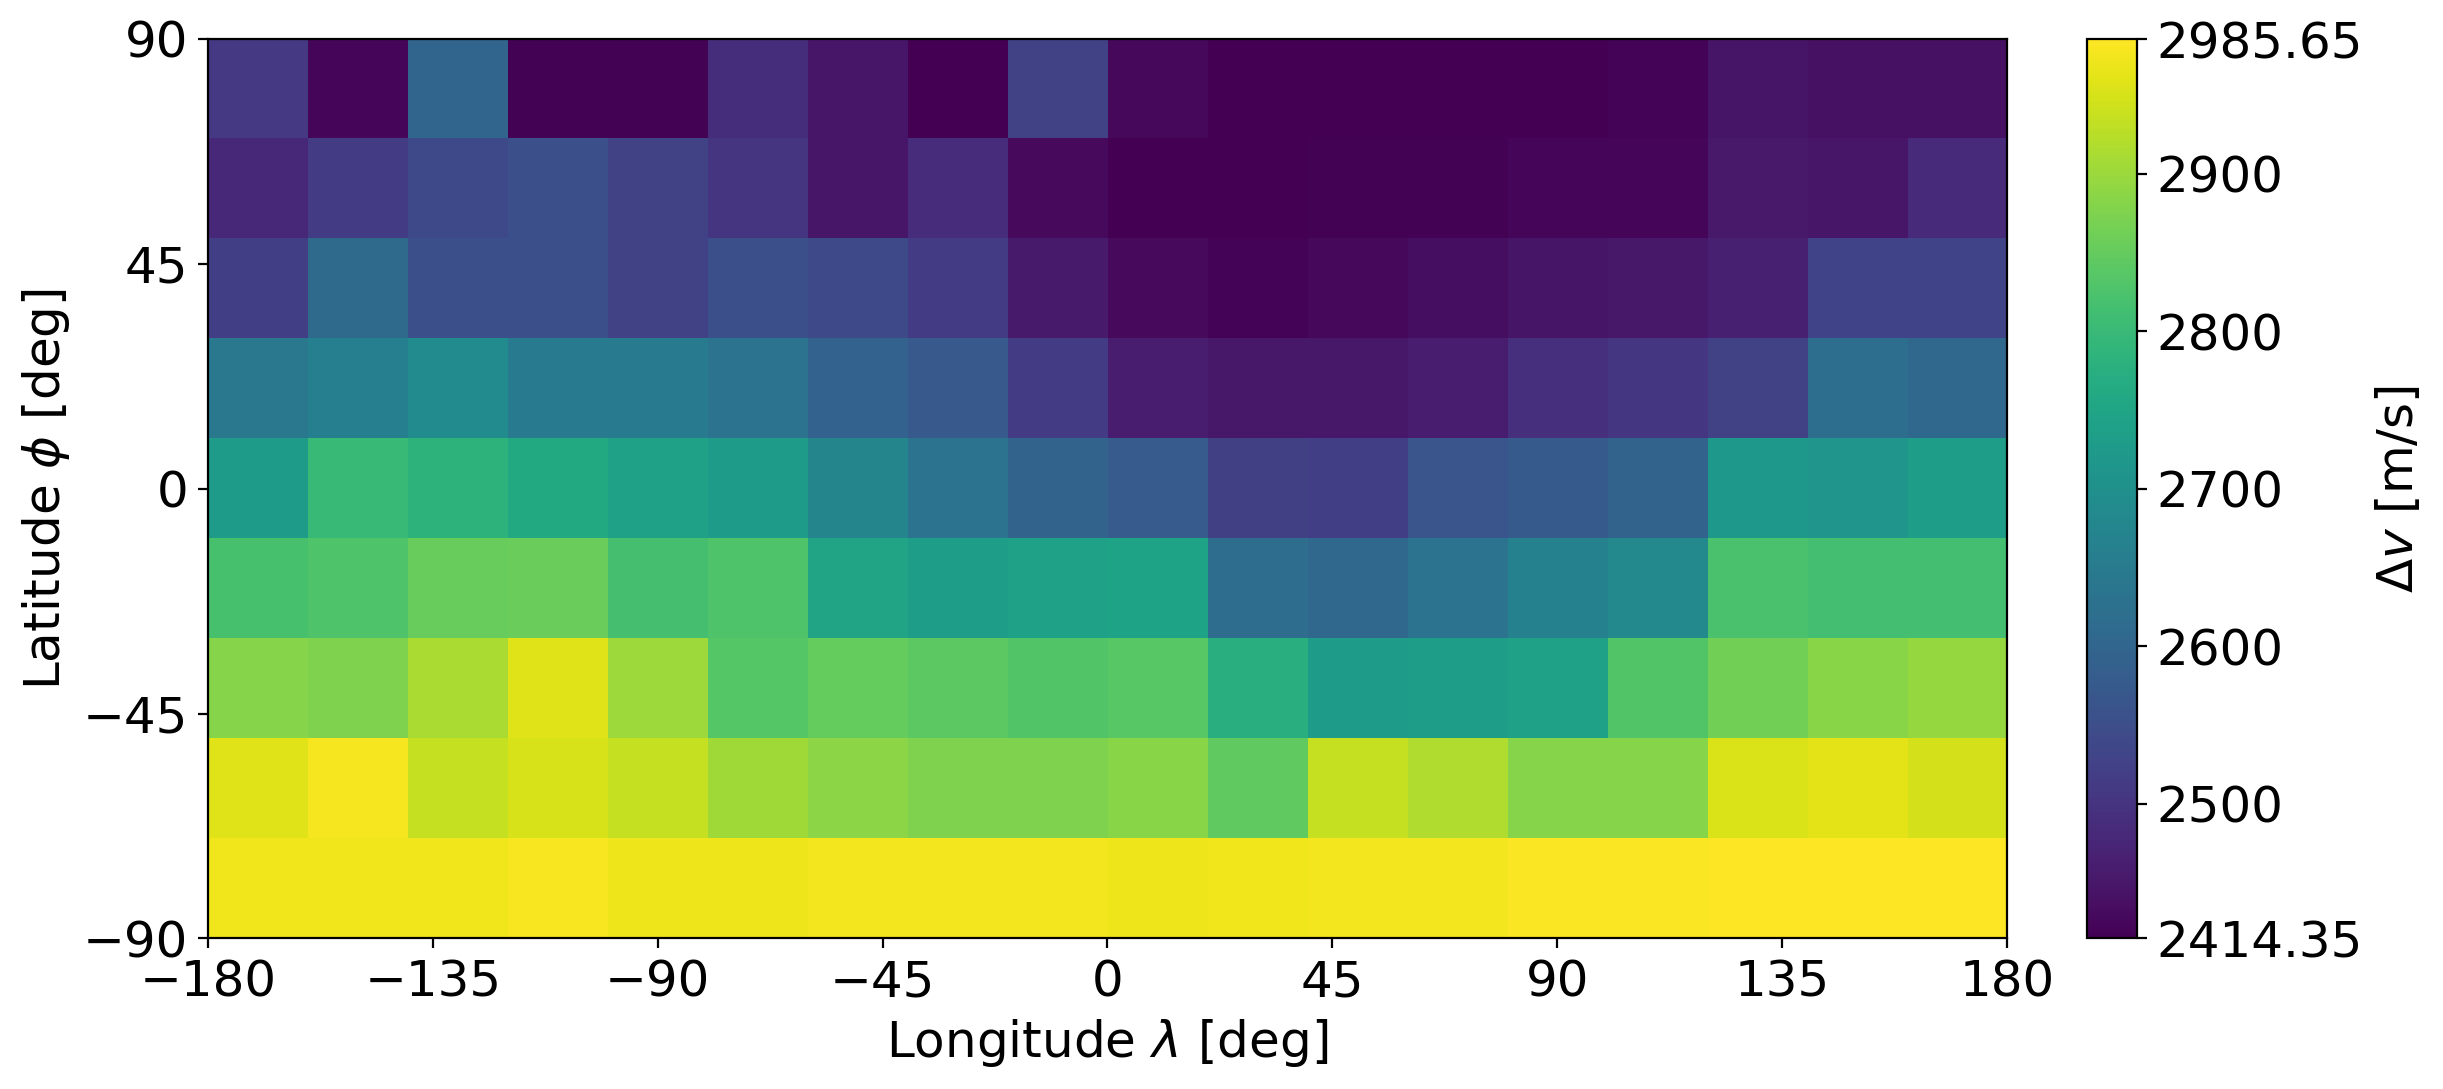

In [7]:
plot_map(dv_map_NRHO,1,'$\Delta v$ [m/s]',tuple((-90,90)),tuple((-180,180)),i_steps=[2500,2600,2700,2800,2900],labelsize=18,silent=True,save="dv_NRHO_raw.pdf")

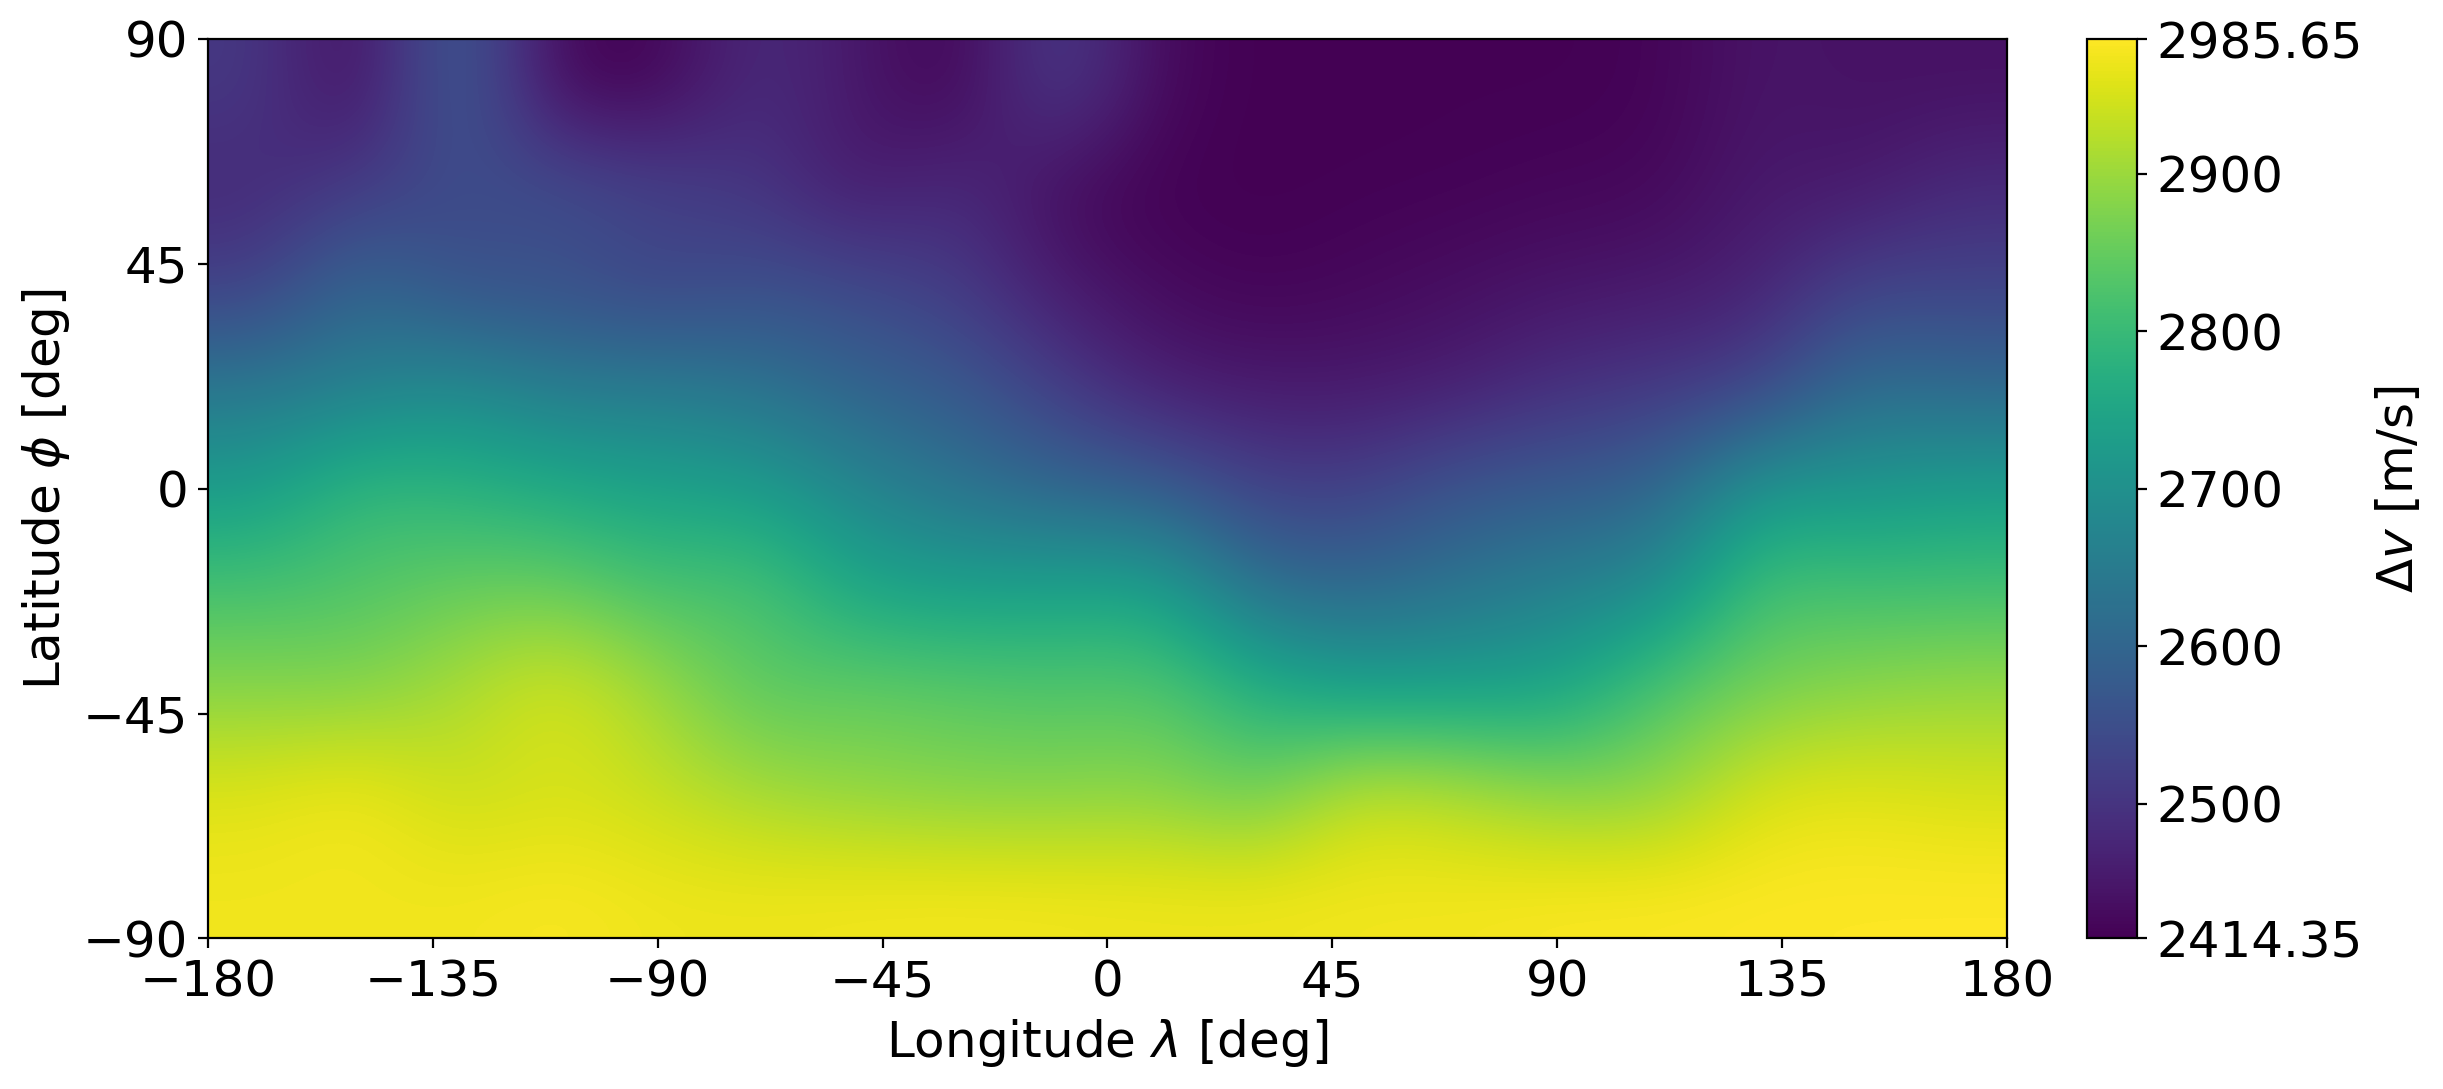

In [8]:
plot_map(dv_map_NRHO,1,'$\Delta v$ [m/s]',tuple((-90,90)),tuple((-180,180)),i_steps=[2500,2600,2700,2800,2900],silent=True,interpolation='bicubic',labelsize=18,save="dv_NRHO.pdf")

## Argonaut (EL3) Sizing - Roundtrip Estimation
    → [1] Moon surface: load Payload (O2), refuel O2
    → [2] Transfer (Launch + Maneuvers)
    → [3] Destination: deliver Payload (O2), refuel H2
    → [4] Transfer (Launch + Maneuvers)
    → [1] ...

In [9]:
# Argonaut initial data
# https://www.esa.int/Science_Exploration/Human_and_Robotic_Exploration/Exploration/Argonaut_European_Large_Logistics_Lander
Argonaut_wet_mass  = 10000 # [kg]
Argonaut_dry_mass  = 1600 # [kg]
Argonaut_payload   = 2100 # [kg]
Argonaut_prop_mass = Argonaut_wet_mass - Argonaut_dry_mass - Argonaut_payload # [kg]

# Argonaut assumption
Argonaut_I_sp = 400 # [s] specific impulse
Argonaut_of_ratio = 6 # [Ox/H] volumetric isp max

In [10]:
def maneuver_result_mass(EEV,m_0,deltaV):
    # from: deltaV = EEV * ln ( m_0 / m_f )
    m_f = m_0 * (1/ np.exp(deltaV/EEV))
    return m_f

def check_fuel(H2,O2,result_table):
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        return False
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        return False
    else:
        return True

# roundtrip calculation via deltaV estimations
def compute_roundtrip(dv, mass_full, payload, H2_initial, H2_refill, dest_name="Destination",printout=False):
    
    mass_dry = Argonaut_dry_mass
    of_ratio = Argonaut_of_ratio
    I_sp = Argonaut_I_sp 
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity
    
    mass = mass_full
    fuel = mass_full - mass_dry - payload
    H2_factor = (1/(of_ratio+1))
    O2_factor = (of_ratio/(of_ratio+1))
    H2 = H2_initial
    O2 = fuel - H2
    
    H2_initial = H2 # for comparing to the end state

    
    #logging in table
    result_table = PrettyTable([" ", "ΔV", "used fuel", "Δ H2", "Δ O2","mass","fuel left","H2","O2","payload"],float_format = "4.0")
    result_table.set_style(MARKDOWN)
    msg = False
    msg_H2 = False
    msg_O2 = False
    
    
    #__________________________________
    # Lunar surface starting condition
    result_table.add_row(["Lunar Surface", "", "", "" , f"+{O2}" , mass, fuel, H2, O2, f'+{payload}' ])
    
    #__________________________________
    # apply launch and maneuver segment
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,dv)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Maneuvers", dv, fuel_used, -H2_factor * fuel_used, -O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    # check H2 for optimization
    if H2 < 1 and H2 > 0:
        msg_H2 = True
    if H2 > 1:
        msg = "H2 leftover"
    
    #__________________________________
    # Gateway exchange
    
    H2 += H2_refill
    fuel = O2 + H2
    mass = mass_dry + fuel
    
    result_table.add_row(["Gateway exchange", "", "", "+"+str(H2_refill),"", mass, fuel, H2, O2, "-"+str(payload) ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    #__________________________________
    # apply maneuver and landing segment
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,dv)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Maneuvers", dv , fuel_used, -H2_factor * fuel_used, -O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    if H2 < H2_initial:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 insufficient", msg
    
    # check O2 for optimization
    if O2 < 1 and O2 > 0:
        msg_O2 = True
    if O2 > 1:
        msg = "O2 leftover"
    
    if msg_H2 == True and msg_O2 == True:
        msg = True
    
    result_table.add_row(["=== SUCCESS ===", "====", "====", "====" , "====" , "====", "====", "====", "====", "====" ])
    if printout: print(result_table, end="\n \n")
    return True, msg

In [52]:
# min(dv_map_NRHO) - normal Argonaut config - capable
compute_roundtrip(dv=np.min(dv_map_NRHO),mass_full=10000,payload=2100,H2_initial=657,H2_refill=935,dest_name="NRHO",printout=True)

|                  |  ΔV  | used fuel | Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |      | +5643 | 10000 |    6300   | 657  | 5643 |  +2100  |
|    Maneuvers     | 2414 |    4596   | -657 | -3940 |  5404 |    1704   |    0 | 1703 |         |
| Gateway exchange |      |           | +935 |       |  4239 |    2639   |  935 | 1703 |  -2100  |
|    Maneuvers     | 2414 |    1948   | -278 | -1670 |  4391 |     691   |  657 |   33 |         |
| === SUCCESS ===  | ==== |    ====   | ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(True, 'O2 leftover')

In [56]:
# max(dv_map_NRHO) - normal Argonaut config - insufficient
compute_roundtrip(dv=np.max(dv_map_NRHO),mass_full=10000,payload=2100,H2_initial=761.5,H2_refill=1036,dest_name="NRHO",printout=True)

|                  |  ΔV  | used fuel |  Δ H2 |   Δ O2  |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:-------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |      |           |       | +5538.5 | 10000 |    6300   |  762 |  5538 |  +2100  |
|    Maneuvers     | 2986 |    5329   |  -761 |  -4567  |  4671 |     971   |    0 |   971 |         |
| Gateway exchange |      |           | +1036 |         |  3607 |    2007   | 1036 |   971 |  -2100  |
|    Maneuvers     | 2986 |    1922   |  -275 |  -1648  |  3785 |      85   |  762 |  -677 |         |
|      ABORT       |      |           |       |         |       |           |      | EMPTY |         |
 


('O2 empty', False)

### Upscaling
Because the standard Argonaut configuration is insufficient to carry out the roundtrip globally<br>
> the launcher (propellant) is scaled up, while keeping the mass_dry constant at 1600 kg
<br>

Assumption: the propulsion system still carries out maneuvers as estimated and structure mass stays constant<br>
Limitation: mass ratio increases with upscaling - pseudo efficiency increase

In [11]:
def converge_NRHO_roundtrip(payload,dv,dest_name="NRHO",silent=False,info=False):
    # init values
    wet_mass_loop = 2*payload # for faster convergence
    H2_initial_loop = 100
    H2_refill_loop = 100
    
    while True:
        ans, msg = False, False
        ans, msg = compute_roundtrip(dv,wet_mass_loop,payload,H2_initial_loop,H2_refill_loop,dest_name)
        if ans == "O2 empty":
            if payload > 20000: wet_mass_loop += 100 # for faster convergence with big rockets
            else: wet_mass_loop += 1
        if ans == "H2 empty":
            H2_initial_loop += 1
            H2_refill_loop += 1
        if ans == "H2 insufficient":
            H2_refill_loop += 1
        if msg == "H2 leftover":
            H2_initial_loop -= 1
        if msg == "O2 leftover":
            wet_mass_loop -= 1
        
        if not silent: print(f'{wet_mass_loop:5.0f} {H2_initial_loop:5.0f} {H2_refill_loop:5.0f} {bool(ans)} {bool(msg)}', end=" \r") # for debugging
            
        if ans == True and msg == True:
            if not silent: print()
            break


    if not silent:
        exchange_ratio = payload / H2_refill_loop
        mass_ratio = wet_mass_loop / Argonaut_dry_mass
        print(f'Exchange Ratio: {exchange_ratio:0.3f}  |  Mass Ratio: {mass_ratio:0.3f}')
        compute_roundtrip(dv,wet_mass_loop,payload,H2_initial_loop,H2_refill_loop,dest_name,printout=True)
    
    if info: return wet_mass_loop, H2_refill_loop, H2_initial_loop
    else:
        return wet_mass_loop, H2_refill_loop

## min(dv_map_NRHO) - several Exchange Ratios - upscaled

In [138]:
# Exchange Ratio 1.5:1
converge_NRHO_roundtrip(1180,np.min(dv_map_NRHO))

 8016   527   785 True True     
Exchange Ratio: 1.503  |  Mass Ratio: 5.010
|                  |  ΔV  | used fuel | Δ H2 |  Δ O2 | mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:----:|:-----:|:----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |      | +4709 | 8016 |    5236   | 527  | 4709 |  +1180  |
|    Maneuvers     | 2414 |    3684   | -526 | -3158 | 4332 |    1552   |    1 | 1551 |         |
| Gateway exchange |      |           | +785 |       | 3937 |    2337   |  786 | 1551 |  -1180  |
|    Maneuvers     | 2414 |    1809   | -258 | -1551 | 3307 |     527   |  527 |    0 |         |
| === SUCCESS ===  | ==== |    ====   | ==== |  ==== | ==== |    ====   | ==== | ==== |   ====  |
 


(8016, 785)

In [139]:
# Exchange Ratio 2:1
converge_NRHO_roundtrip(1738,np.min(dv_map_NRHO))

 9149   601   869 True True    
Exchange Ratio: 2.000  |  Mass Ratio: 5.718
|                  |  ΔV  | used fuel | Δ H2 |  Δ O2 | mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:----:|:-----:|:----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |      | +5210 | 9149 |    5811   | 601  | 5210 |  +1738  |
|    Maneuvers     | 2414 |    4205   | -601 | -3604 | 4944 |    1606   |    0 | 1606 |         |
| Gateway exchange |      |           | +869 |       | 4075 |    2475   |  869 | 1606 |  -1738  |
|    Maneuvers     | 2414 |    1873   | -268 | -1605 | 3940 |     602   |  602 |    0 |         |
| === SUCCESS ===  | ==== |    ====   | ==== |  ==== | ==== |    ====   | ==== | ==== |   ====  |
 


(9149, 869)

In [147]:
# Exchange Ratio 2.5:1
converge_NRHO_roundtrip(2430,np.min(dv_map_NRHO))

10553   693   972 True True    
Exchange Ratio: 2.500  |  Mass Ratio: 6.596
|                  |  ΔV  | used fuel | Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |      | +5830 | 10553 |    6523   | 693  | 5830 |  +2430  |
|    Maneuvers     | 2414 |    4850   | -693 | -4157 |  5703 |    1673   |    0 | 1673 |         |
| Gateway exchange |      |           | +972 |       |  4245 |    2645   |  972 | 1673 |  -2430  |
|    Maneuvers     | 2414 |    1951   | -279 | -1672 |  4724 |     694   |  693 |    0 |         |
| === SUCCESS ===  | ==== |    ====   | ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(10553, 972)

In [158]:
# Exchange Ratio 3:1
converge_NRHO_roundtrip(3312,np.min(dv_map_NRHO))

12345   811  1104 True True      
Exchange Ratio: 3.000  |  Mass Ratio: 7.716
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |       | +6622 | 12345 |    7433   | 811  | 6622 |  +3312  |
|    Maneuvers     | 2414 |    5674   |  -811 | -4863 |  6671 |    1759   |    0 | 1759 |         |
| Gateway exchange |      |           | +1104 |       |  4463 |    2863   | 1104 | 1759 |  -3312  |
|    Maneuvers     | 2414 |    2051   |  -293 | -1758 |  5724 |     812   |  811 |    0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(12345, 1104)

## max(dv_map_NRHO) - several Exchange Ratios - upscaled

In [159]:
# Standard Argonaut mass ratio (10000 kg wet/ 1600 kg dry)
# make max(dv_map_NRHO) possible by reducing payload
# -> Exchange Ratio 0.66:1
converge_NRHO_roundtrip(761,np.max(dv_map_NRHO))

10001   762  1147 True True     
Exchange Ratio: 0.663  |  Mass Ratio: 6.251
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |       | +6878 | 10001 |    7640   | 762  | 6878 |   +761  |
|    Maneuvers     | 2986 |    5329   |  -761 | -4568 |  4672 |    2311   |    1 | 2310 |         |
| Gateway exchange |      |           | +1147 |       |  5058 |    3458   | 1148 | 2310 |   -761  |
|    Maneuvers     | 2986 |    2695   |  -385 | -2310 |  3124 |     763   |  763 |    0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(10001, 1147)

In [160]:
# Standard Argonaut Payload (2100 kg)
# in upscaled version
# -> Exchange Ratio 1.45:1
converge_NRHO_roundtrip(2100,np.max(dv_map_NRHO))

13408  1021  1448 True True        
Exchange Ratio: 1.450  |  Mass Ratio: 8.380
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |       | +8687 | 13408 |    9708   | 1021 | 8687 |  +2100  |
|    Maneuvers     | 2986 |    7145   | -1021 | -6124 |  6263 |    2563   |    0 | 2563 |         |
| Gateway exchange |      |           | +1448 |       |  5611 |    4011   | 1448 | 2563 |  -2100  |
|    Maneuvers     | 2986 |    2990   |  -427 | -2563 |  4721 |    1021   | 1021 |    0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(13408, 1448)

In [161]:
# Exchange Ratio 1.5:1
converge_NRHO_roundtrip(2210,np.max(dv_map_NRHO))

13688  1042  1473 True True         
Exchange Ratio: 1.500  |  Mass Ratio: 8.555
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |       | +8836 | 13688 |    9878   | 1042 | 8836 |  +2210  |
|    Maneuvers     | 2986 |    7294   | -1042 | -6252 |  6394 |    2584   |    0 | 2584 |         |
| Gateway exchange |      |           | +1473 |       |  5657 |    4057   | 1473 | 2584 |  -2210  |
|    Maneuvers     | 2986 |    3015   |  -431 | -2584 |  4853 |    1043   | 1042 |    0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(13688, 1473)

In [162]:
# Exchange Ratio 2:1
converge_NRHO_roundtrip(3550,np.max(dv_map_NRHO))

17100  1302  1775 True True     
Exchange Ratio: 2.000  |  Mass Ratio: 10.688
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2  |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |      |           |       | +10648 | 17100 |   11950   | 1302 | 10648 |  +3550  |
|    Maneuvers     | 2986 |    9112   | -1302 | -7810  |  7988 |    2838   |    0 |  2838 |         |
| Gateway exchange |      |           | +1775 |        |  6213 |    4613   | 1775 |  2838 |  -3550  |
|    Maneuvers     | 2986 |    3311   |  -473 | -2838  |  6452 |    1302   | 1302 |     0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ====  |  ==== |    ====   | ==== |  ==== |   ====  |
 


(17100, 1775)

In [163]:
# Exchange Ratio 2.5:1
converge_NRHO_roundtrip(5585,np.max(dv_map_NRHO))

22284  1697  2234 True True      
Exchange Ratio: 2.500  |  Mass Ratio: 13.928
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2  |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |      |           |       | +13402 | 22284 |   15099   | 1697 | 13402 |  +5585  |
|    Maneuvers     | 2986 |   11874   | -1696 | -10178 | 10410 |    3225   |    1 |  3224 |         |
| Gateway exchange |      |           | +2234 |        |  7059 |    5459   | 2235 |  3224 |  -5585  |
|    Maneuvers     | 2986 |    3761   |  -537 | -3224  |  8882 |    1697   | 1697 |     0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ====  |  ==== |    ====   | ==== |  ==== |   ====  |
 


(22284, 2234)

In [164]:
# Exchange Ratio 3:1
converge_NRHO_roundtrip(9030,np.max(dv_map_NRHO))

31053  2364  3010 True True       
Exchange Ratio: 3.000  |  Mass Ratio: 19.408
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2  |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |      |           |       | +18059 | 31053 |   20423   | 2364 | 18059 |  +9030  |
|    Maneuvers     | 2986 |   16547   | -2364 | -14183 | 14506 |    3876   |    0 |  3876 |         |
| Gateway exchange |      |           | +3010 |        |  8486 |    6886   | 3010 |  3876 |  -9030  |
|    Maneuvers     | 2986 |    4522   |  -646 | -3876  | 12994 |    2364   | 2364 |     0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ====  |  ==== |    ====   | ==== |  ==== |   ====  |
 


(31053, 3010)

In [12]:
# prepare data for plotting

# scatter points
#                   std   1.5  2.0  2.5  3.0
x_min_points =     [2100,1180,1738,2430,3312] # min(dv_map_NRHO)
x_max_points = [761,2100,2210,3550,5585,9030] # max(dv_map_NRHO)

y1_min_points = []
y2_min_points = []
y1_max_points = []
y2_max_points = []

print('Compute Scatter Points for min(dv_map_NRHO)')
for i in tqdm(x_min_points):
    ans1 , ans2 = converge_NRHO_roundtrip(i,np.min(dv_map_NRHO),silent=True)
    y1_min_points.append(ans1)
    y2_min_points.append(ans2)
print('Compute Scatter Points for max(dv_map_NRHO)')
for i in tqdm(x_max_points):
    ans1 , ans2 = converge_NRHO_roundtrip(i,np.max(dv_map_NRHO),silent=True)
    y1_max_points.append(ans1)
    y2_max_points.append(ans2)

x_min_points = np.array(x_min_points)
x_max_points = np.array(x_max_points)

y1_min_points = np.array(y1_min_points)
y1_min_points_ratio = y1_min_points/1600

y1_max_points = np.array(y1_max_points)
y1_max_points_ratio = y1_max_points/1600

y2_min_points = np.array(y2_min_points)
y2_min_points_ratio = x_min_points/y2_min_points

y2_max_points = np.array(y2_max_points)
y2_max_points_ratio = x_max_points/y2_max_points

# continuous plot
x_payload = np.linspace(1,6000,100)
y1_min = []
y2_min = []
y1_max = []
y2_max = []
print('Compute Linspace for min(dv_map_NRHO)')
for i in tqdm(x_payload):
    ans1 , ans2 = converge_NRHO_roundtrip(i,np.min(dv_map_NRHO),silent=True)
    y1_min.append(ans1)
    y2_min.append(ans2)
print('Compute Linspace for max(dv_map_NRHO)')
for i in tqdm(x_payload):
    ans1 , ans2 = converge_NRHO_roundtrip(i,np.max(dv_map_NRHO),silent=True)
    y1_max.append(ans1)
    y2_max.append(ans2)
    
x = np.array(x_payload)
y1_min = np.array(y1_min)
y2_min = np.array(y2_min)
y1_max = np.array(y1_max)
y2_max = np.array(y2_max)

ex_ratio_min = x/y2_min
ex_ratio_max = x/y2_max

m_ratio_min = y1_min/1600 # constant dry_mass of 1600 kg
m_ratio_max = y1_max/1600 # constant dry_mass of 1600 kg

Compute Scatter Points for min(dv_map_NRHO)


  0%|          | 0/5 [00:00<?, ?it/s]

Compute Scatter Points for max(dv_map_NRHO)


  0%|          | 0/6 [00:00<?, ?it/s]

Compute Linspace for min(dv_map_NRHO)


  0%|          | 0/100 [00:00<?, ?it/s]

Compute Linspace for max(dv_map_NRHO)


  0%|          | 0/100 [00:00<?, ?it/s]

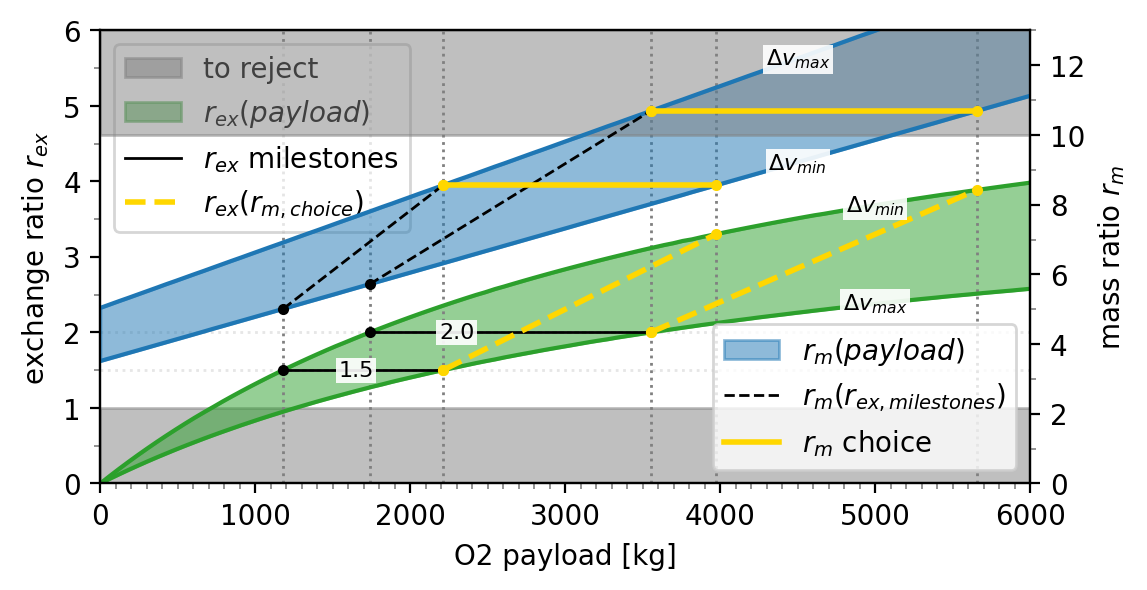

In [69]:
# plot Exchange Ratio: Oxygen for Hydrogen
# plot Mass Ratio of Launcher

ratio_milestone_color = 'black'
dot_color = 'black'
m_ratio_milestone_color = 'gold'
m_dot_color = 'gold'

# mass ratio choice data from next cells
x_r_m_1 = [x_max_points[2],3974]
x_r_m_2 = [x_max_points[3],5655]
y_r_m_1 = [[1.5],[3.303]]
y_r_m_2 = [[2.0],[3.889]]
y2_r_m_1 = [8.555]*2
y2_r_m_2 = [10.688]*2

#plt.figure(figsize=(6,3), dpi=200)
fig, ax1 = plt.subplots(figsize=(6,3),dpi=200)
ax2 = ax1.twinx()

#plt.title("Lunar Gateway: Mass Exchange ratio of O2 for H2")
ax1.set_xlim(0, max(x_payload))
ax1.set_ylim(0, 6)

ax1.axhspan(0, 1, color='0.5', alpha=0.5,label='to reject')

#ax1.axhline(y=1.0,linewidth=1, color='0.9',linestyle="--")
ax1.axhline(y=1.5,linewidth=1, color='0.9',linestyle=":")
ax1.axhline(y=2.0,linewidth=1, color='0.9',linestyle=":")
#ax1.axhline(y=2.5,linewidth=1, color='0.9',linestyle=":")
#ax1.axhline(y=3.0,linewidth=1, color='0.9',linestyle=":")

v_width = 1

ax1.axvline(x=x_min_points[1],linewidth=v_width, color='0.5',linestyle=":")
ax1.axvline(x=x_min_points[2],linewidth=v_width, color='0.5',linestyle=":")
#ax1.axvline(x=x_min_points[3],linewidth=v_width, color='0.5',linestyle=":")
#ax1.axvline(x=x_min_points[4],linewidth=v_width, color='0.5',linestyle=":")

ax1.axvline(x=x_max_points[2],linewidth=v_width, color='0.5',linestyle=":")
ax1.axvline(x=x_max_points[3],linewidth=v_width, color='0.5',linestyle=":")
#ax1.axvline(x=x_max_points[4],linewidth=v_width, color='0.5',linestyle=":")
#ax1.axvline(x=x_max_points[5],linewidth=v_width, color='0.5',linestyle=":")

ax1.axvline(x=x_r_m_1[1],linewidth=v_width, color='0.5',linestyle=":")
ax1.axvline(x=x_r_m_2[1],linewidth=v_width, color='0.5',linestyle=":")

ax1.plot(x,ex_ratio_min,c='tab:green') #label='ratio as f(payload)'
ax1.plot(x,ex_ratio_max,c='tab:green') #label='ratio as f(payload)'

# Fill the area between with color
ax1.fill_between(x, ex_ratio_min, ex_ratio_max, where=(ex_ratio_min > ex_ratio_max), color='tab:green', alpha=0.5, label='$r_{ex} (payload)$')

# horizontal lines for exchange ratio milestones
ax1.plot([x_min_points[1],x_max_points[2]],[1.5]*2,color=ratio_milestone_color,linewidth=1,label='$r_{ex}$ milestones')
ax1.plot([x_min_points[2],x_max_points[3]],[2.0]*2,color=ratio_milestone_color,linewidth=1)
#ax1.plot([x_min_points[3],x_max_points[4]],[2.5]*2,color=ratio_milestone_color,linewidth=1)
#ax1.plot([x_min_points[4],x_max_points[5]],[3.0]*2,color=ratio_milestone_color,linewidth=1)

# constant mass ratio
ax1.plot(x_r_m_1,y_r_m_1,color=m_ratio_milestone_color,linewidth=2,linestyle="--",label='$r_{ex}(r_{m,choice})$')
ax1.plot(x_r_m_2,y_r_m_2,color=m_ratio_milestone_color,linewidth=2,linestyle="--")

# mass ratio points
ax1.plot(x_r_m_1,y_r_m_1,'.',color=m_dot_color)
ax1.plot(x_r_m_2,y_r_m_2,'.',color=m_dot_color)

#ax1.plot(x_min_points[0],y2_min_points_ratio[0],'.',color='0.3',label='standard EL3 mass ratio and payload')
ax1.plot(x_min_points[1:-2],y2_min_points_ratio[1:-2],'.',color=dot_color)

#ax1.plot(x_max_points[0],y2_max_points_ratio[0],'.',color='0.3')
#ax1.plot(x_max_points[1],y2_max_points_ratio[1],'.',color='tab:grey')
ax1.plot(x_max_points[2:-2],y2_max_points_ratio[2:-2],'.',color=m_dot_color)


ax1.set_ylabel("exchange ratio $r_{ex}$")
ax1.set_xlabel("O2 payload [kg]")

ax1.xaxis.set_major_locator(MultipleLocator(1000))
ax1.xaxis.set_minor_locator(MultipleLocator(100))
ax1.tick_params(axis='x', which='minor', colors='0.5')

ax2.set_xlim(0, max(x_payload))
ax2.set_ylim(0, 13)

#ax2.axhline(y=10 ,linewidth=1, color='0.9',linestyle="--")

ax2.plot(x,m_ratio_min,color='tab:blue')
ax2.plot(x,m_ratio_max,color='tab:blue')

# Fill the area between with color
ax2.fill_between(x, m_ratio_min, m_ratio_max, where=(m_ratio_max > m_ratio_min), color='tab:blue', alpha=0.5, label='$r_m (payload)$')

# equal lines for exchange ratio milestones
ax2.plot([x_min_points[1],x_max_points[2]],[y1_min_points_ratio[1],y1_max_points_ratio[2]],color=ratio_milestone_color,linewidth=1,linestyle="--",label='$r_{m}(r_{ex,milestones})$')
ax2.plot([x_min_points[2],x_max_points[3]],[y1_min_points_ratio[2],y1_max_points_ratio[3]],color=ratio_milestone_color,linewidth=1,linestyle="--")
#ax2.plot([x_min_points[3],x_max_points[4]],[y1_min_points_ratio[3],y1_max_points_ratio[4]],color=ratio_milestone_color,linewidth=1,linestyle="--")
#ax2.plot([x_min_points[4],x_max_points[5]],[y1_min_points_ratio[4],y1_max_points_ratio[5]],color=ratio_milestone_color,linewidth=1,linestyle="--")

# plot constant mass ratio
ax2.plot(x_r_m_1,[y1_max_points_ratio[2]]*2,color=m_ratio_milestone_color,linewidth=2,label='$r_{m}$ choice')
ax2.plot(x_r_m_2,[y1_max_points_ratio[3]]*2,color=m_ratio_milestone_color,linewidth=2)

# mass ratio point
ax2.plot(x_r_m_1,y2_r_m_1,'.',color=m_dot_color)
ax2.plot(x_r_m_2,y2_r_m_2,'.',color=m_dot_color)

#ax2.plot(x_min_points[0],y1_min_points_ratio[0],'.',color='0.3')
#ax2.plot(x_min_points[1],y1_min_points_ratio[1],'.',color='tab:grey')
ax2.plot(x_min_points[1:-2],y1_min_points_ratio[1:-2],'.',color=dot_color)

#ax2.plot(x_max_points[0],y1_max_points_ratio[0],'.',color='0.3')
#ax2.plot(x_max_points[1],y1_max_points_ratio[1],'.',color='tab:grey')
ax2.plot(x_max_points[2:-2],y1_max_points_ratio[2:-2],'.',color=m_dot_color)

ax2.axhspan(10, 13, color='0.5', alpha=0.5)

ax2.set_ylabel("mass ratio $r_{m}$")
ax2.set_xlabel("O2 payload [kg]")

ax2.legend(loc='lower right')
ax1.legend(loc='upper left')

ax2.set_axisbelow(True)
ax2.xaxis.set_major_locator(MultipleLocator(1000))
ax2.xaxis.set_minor_locator(MultipleLocator(100))
ax2.tick_params(axis='x', which='minor', colors='0.5')

ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.tick_params(axis='y', which='minor', colors='0.5')

ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(axis='y', which='minor', colors='0.5')

ax1.text(5000, 3.6, "$\Delta v_{min}$", fontsize=8, ha='center',bbox=dict(facecolor='white', alpha=0.9, edgecolor='none',pad=1))
ax1.text(5000, 2.3, "$\Delta v_{max}$", fontsize=8, ha='center',bbox=dict(facecolor='white', alpha=0.9, edgecolor='none',pad=1))

ax2.text(4500, 9, "$\Delta v_{min}$", fontsize=8, ha='center',bbox=dict(facecolor='white', alpha=0.9, edgecolor='none',pad=1))
ax2.text(4500, 12, "$\Delta v_{max}$", fontsize=8, ha='center',bbox=dict(facecolor='white', alpha=0.9, edgecolor='none',pad=1))

ax1.text(1650, 1.42, "1.5", fontsize=8, ha='center',bbox=dict(facecolor='white', alpha=0.9, edgecolor='none',pad=1))
ax1.text(2300, 1.92, "2.0", fontsize=8, ha='center',bbox=dict(facecolor='white', alpha=0.9, edgecolor='none',pad=1))

plt.savefig('doc\\img\\upscale_ratios_raw.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

### A) upscaled version with **1.5** exchange ratio

#### dv Maximum

In [257]:
Launcher_dry_mass = 1600
Launcher_payload = 2210
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.max(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("     LAUNCHER SPECIFICATION")
print("     for global dv Maximum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

13688  1042  1473 True True     
Exchange Ratio: 1.500  |  Mass Ratio: 8.555
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |       | +8836 | 13688 |    9878   | 1042 | 8836 |  +2210  |
|    Maneuvers     | 2986 |    7294   | -1042 | -6252 |  6394 |    2584   |    0 | 2584 |         |
| Gateway exchange |      |           | +1473 |       |  5657 |    4057   | 1473 | 2584 |  -2210  |
|    Maneuvers     | 2986 |    3015   |  -431 | -2584 |  4853 |    1043   | 1042 |    0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
     LAUNCHER SPECIFICATION
     for global dv Maximum
┌────────────────┬──────────────┐
│    wet mass    │   13688 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    2210 [kg] │
│   O2 refill    │    8836 [kg

#### dv Minimum

In [270]:
# create Launcher with same Mass Ratio as max_dv launcher
# -> reach Mass Ratio = 8.555 
Launcher_dry_mass = 1600
Launcher_payload = 3974
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.min(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("     LAUNCHER SPECIFICATION")
print("     for global dv Minimum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

13688   899  1203 True True    
Exchange Ratio: 3.303  |  Mass Ratio: 8.555
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |       | +7215 | 13688 |    8114   | 899  | 7215 |  +3974  |
|    Maneuvers     | 2414 |    6291   |  -899 | -5393 |  7397 |    1823   |    0 | 1822 |         |
| Gateway exchange |      |           | +1203 |       |  4626 |    3026   | 1203 | 1822 |  -3974  |
|    Maneuvers     | 2414 |    2126   |  -304 | -1822 |  6474 |     900   |  900 |    0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
     LAUNCHER SPECIFICATION
     for global dv Minimum
┌────────────────┬──────────────┐
│    wet mass    │   13688 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    3974 [kg] │
│   O2 refill    │    7215 [kg]

### B) upscaled version with **2.0** exchange ratio

#### dv Maximum

In [272]:
Launcher_dry_mass = 1600
Launcher_payload = 3550
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.max(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("     LAUNCHER SPECIFICATION")
print("     for global dv Maximum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

17100  1302  1775 True True       
Exchange Ratio: 2.000  |  Mass Ratio: 10.688
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2  |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |      |           |       | +10648 | 17100 |   11950   | 1302 | 10648 |  +3550  |
|    Maneuvers     | 2986 |    9112   | -1302 | -7810  |  7988 |    2838   |    0 |  2838 |         |
| Gateway exchange |      |           | +1775 |        |  6213 |    4613   | 1775 |  2838 |  -3550  |
|    Maneuvers     | 2986 |    3311   |  -473 | -2838  |  6452 |    1302   | 1302 |     0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ====  |  ==== |    ====   | ==== |  ==== |   ====  |
 
     LAUNCHER SPECIFICATION
     for global dv Maximum
┌────────────────┬──────────────┐
│    wet mass    │   17100 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    3550 [kg] │
│   O2 refill

#### dv Minimum (keep Mass Ratio constant)

In [279]:
# create Launcher with same Mass Ratio as max_dv launcher
# -> reach Mass Ratio = 10.688

Launcher_dry_mass = 1600
Launcher_payload = 5655
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.min(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("     LAUNCHER SPECIFICATION")
print("     for global dv Minimum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

17101  1123  1454 True True    
Exchange Ratio: 3.889  |  Mass Ratio: 10.688
|                  |  ΔV  | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |       | +8723 | 17101 |    9846   | 1123 | 8723 |  +5655  |
|    Maneuvers     | 2414 |    7860   | -1123 | -6737 |  9241 |    1986   |    0 | 1986 |         |
| Gateway exchange |      |           | +1454 |       |  5040 |    3440   | 1454 | 1986 |  -5655  |
|    Maneuvers     | 2414 |    2316   |  -331 | -1986 |  8378 |    1123   | 1123 |    0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
     LAUNCHER SPECIFICATION
     for global dv Minimum
┌────────────────┬──────────────┐
│    wet mass    │   17101 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    5655 [kg] │
│   O2 refill    │    8723 [kg

In [1]:
r_m_1 = '8.555'
r_m_2 = '10.688'

## Mass Costs per Year (quick analysis)

In [8]:
# both (min/max) using up the 23.9 t Oxygen per year
# for A) Ex = 1.5
# apply 23.9 t Oxygen Supply

"""
     LAUNCHER SPECIFICATION
     for global dv Maximum
┌────────────────┬──────────────┐
│    wet mass    │   13688 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    2210 [kg] │
│   O2 refill    │    8836 [kg] │
│   H2 refill    │    1473 [kg] │
│   Mass Ratio   │   8.555      │
│ Exchange Ratio │   1.500      │
└────────────────┴──────────────┘
     LAUNCHER SPECIFICATION
     for global dv Minimum
┌────────────────┬──────────────┐
│    wet mass    │   13688 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    3974 [kg] │
│   O2 refill    │    7215 [kg] │
│   H2 refill    │    1203 [kg] │
│   Mass Ratio   │   8.555      │
│ Exchange Ratio │   3.303      │
└────────────────┴──────────────┘
"""

# compare fuel costs for delivering the same amount of payload [1kg]
maxdv_payload = 2210 # [kg]
maxdv_O2_consumption = 8836 # [kg]
maxdv_H2_consumption = 1473 # [kg]
maxdv_Fuel_consumption = maxdv_O2_consumption + maxdv_H2_consumption
maxdv_costs_per_kg = maxdv_Fuel_consumption / maxdv_payload

print(f'maxdv_costs_per_kg = {maxdv_costs_per_kg:5.3f} [kg Fuel/ kg Payload]')

mindv_payload = 3974 # [kg]
mindv_O2_consumption = 7215 # [kg]
mindv_H2_consumption = 1203 # [kg]
mindv_Fuel_consumption = mindv_O2_consumption + mindv_H2_consumption
mindv_costs_per_kg = mindv_Fuel_consumption / mindv_payload

print(f'mindv_costs_per_kg = {mindv_costs_per_kg:5.3f} [kg Fuel/ kg Payload]')
print()

maxdv_costs_per_year = 23.9 * 1000 * maxdv_costs_per_kg

print(f'maxdv_costs_per_year = {maxdv_costs_per_year:5.2f} [kg Fuel/ year]')

mindv_costs_per_year = 23.9 * 1000 * mindv_costs_per_kg

print(f'mindv_costs_per_year = {mindv_costs_per_year:5.2f} [kg Fuel/ year]')

maxdv_costs_per_kg = 4.665 [kg Fuel/ kg Payload]
mindv_costs_per_kg = 2.118 [kg Fuel/ kg Payload]

maxdv_costs_per_year = 111486.47 [kg Fuel/ year]
mindv_costs_per_year = 50626.62 [kg Fuel/ year]


## Cost per year map
Method was required in an old approach as Delta v map had a higher resolution - low resolution could be resolved directly. <br>
Old data had exchange ratio 1.5 and 2.5 instead 1.5 and 2.0 -> variable names are off

as converge_NRHO_roundtrip() takes ~2 sec to finish an iterative solving of the original (23040, 11520) data is not practical (16.8 years)
<br>
however the relationship from dv to the costs per kg can be sampled into a fitting function to supply a mapping function that converts the whole dv map at once

### fitting data
vary dv and keep mass ratio constant

In [70]:
def cost_from_dv_via_mass_ratio(mass_ratio,dv,start_value):
    tolerance = 0.01
    increment = 1000
    
    Launcher_dry_mass = 1600
    Launcher_payload = start_value
    
    while True:
        increment_old = increment
        Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,dv,info=True,silent=True)
        Launcher_mass_ratio = Launcher_wet_mass/Launcher_dry_mass

        delta = abs(Launcher_mass_ratio - mass_ratio)
        
        if delta < 1 :
            increment = round(100 + 0.5 * delta*100,2)
        if delta < 0.1:
            increment = (delta *120) **2

        #print('delta',delta,'increment',increment)

        if Launcher_mass_ratio < mass_ratio + tolerance and Launcher_mass_ratio > mass_ratio - tolerance :
            break
        elif Launcher_mass_ratio < mass_ratio:
            Launcher_payload += increment
        elif Launcher_mass_ratio > mass_ratio:
            Launcher_payload -= increment
            
    Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial
    
    Fuel_consumption = Launcher_O2_refill + Launcher_H2_refill
    spent_fuel_per_kg = Fuel_consumption / Launcher_payload
    spent_O2_per_kg = Launcher_O2_refill / Launcher_payload
    spent_H2_per_kg = Launcher_H2_refill / Launcher_payload
    
    return spent_fuel_per_kg, spent_O2_per_kg, spent_H2_per_kg

In [71]:
# takes approx. 10 min to complete

mass_ratio_1 = 8.555
mass_ratio_2 = 10.688

x = np.linspace(np.min(dv_map_NRHO),np.max(dv_map_NRHO),100)

u_1_5 = np.zeros(x.shape) # total fuel / kg payload
v_1_5 = np.zeros(x.shape) # O2 / kg payload
w_1_5 = np.zeros(x.shape) # H2 / kg payload

u_2_5 = np.zeros(x.shape) # total fuel / kg payload
v_2_5 = np.zeros(x.shape) # O2 / kg payload
w_2_5 = np.zeros(x.shape) # H2 / kg payload


with tqdm(total=len(x)*2) as pbar:
    for i , value in enumerate(x):
        u_1_5[i] , v_1_5[i] , w_1_5[i] = cost_from_dv_via_mass_ratio(mass_ratio_1,value,start_value=3000) # 1.5 exchange ratio
        pbar.update(1)
        u_2_5[i] , v_2_5[i] , w_2_5[i] = cost_from_dv_via_mass_ratio(mass_ratio_2,value,start_value=5000) # 2.5 exchange ratio
        pbar.update(1)

  0%|          | 0/200 [00:00<?, ?it/s]

f(x)_1.5 = 0.0000044131*x² + -0.0195202953*x + 23.5579555120
f(x)_2.5 = 0.0000023605*x² + -0.0098327811*x + 11.7957890986


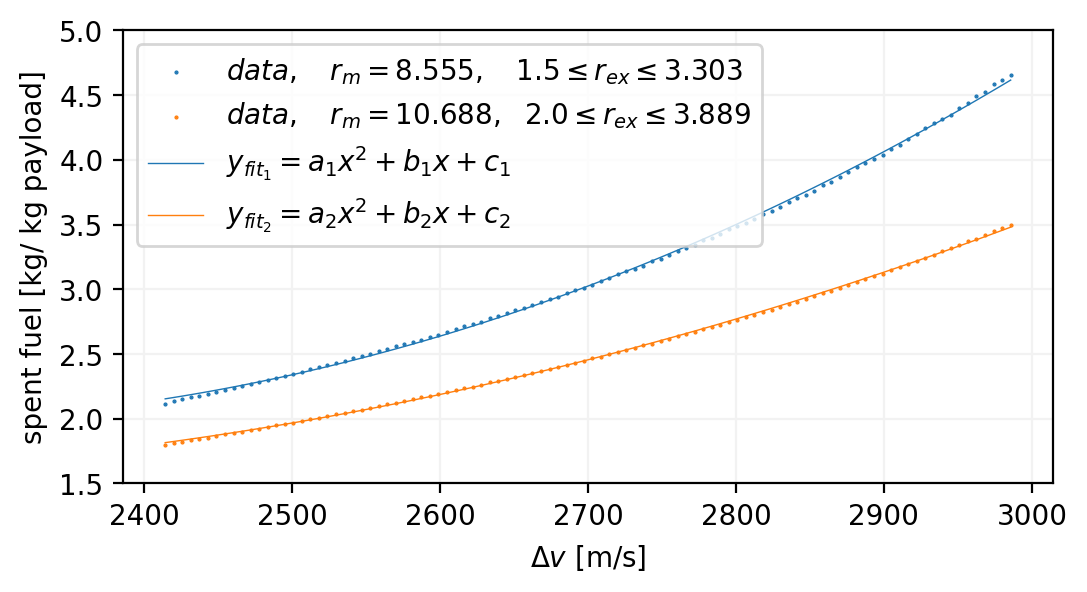

In [72]:
# (u) total spent fuel
#-------------------------------------------------
# linear fit
s_1_5, m_1_5, n_1_5 = np.polyfit(x, u_1_5, 2)
s_2_5, m_2_5, n_2_5 = np.polyfit(x, u_2_5, 2)
y_pred_1_5 = s_1_5 *(x**2) + m_1_5 * x + n_1_5
y_pred_2_5 = s_2_5 *(x**2) + m_2_5 * x + n_2_5
print(f'f(x)_1.5 = {s_1_5:0.10f}*x² + {m_1_5:0.10f}*x + {n_1_5:0.10f}')
print(f'f(x)_2.5 = {s_2_5:0.10f}*x² + {m_2_5:0.10f}*x + {n_2_5:0.10f}')

plt.figure(figsize=(6,3), dpi=200)

#plt.title("total spent fuel mapping from delta v")
plt.grid(axis='both', color='0.95')

plt.scatter(x,u_1_5,marker='.', s=1, color='tab:blue',label=r'$data, \quad r_{m}=8.555, \quad 1.5 \leq r_{ex} \leq 3.303$')
plt.scatter(x,u_2_5,marker='.', s=1, color='tab:orange',label=r'$data, \quad r_{m}=10.688, \ \ 2.0 \leq r_{ex} \leq 3.889$')

plt.plot(x,y_pred_1_5,label=r'$y_{fit_{1}}= a_1 x^2 + b_1 x + c_1$', linewidth=0.5)
plt.plot(x,y_pred_2_5,label=r'$y_{fit_{2}}= a_2 x^2 + b_2 x + c_2$', linewidth=0.5)

plt.ylabel("spent fuel [kg/ kg payload]")
plt.xlabel("$\Delta v$ [m/s]")
plt.legend()
plt.ylim(1.5,5)
ax = plt.gca()
ax.set_axisbelow(True)
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.2))
#for i, label in enumerate(ax.xaxis.get_ticklabels()):
#    if i % 5 != 1:
#        label.set_visible(False)
#ax.tick_params(axis='y', which='minor', colors='0.5')
#ax.tick_params(axis='x', which='minor', colors='0.5')
plt.savefig('doc\\img\\spent_total_mapping.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

spent O2
f(x)_1.25 = 0.0036947465081720162*x + -7.278170546974129
f(x)_1.5  = 0.0024974189222397455*x + -4.582602936704612
spent H2
f(x)_1.5 = 0.0006159020031946877*x + -1.2131918070960883
f(x)_2.5 = 0.0004163360450348754*x + -0.7639330499728623


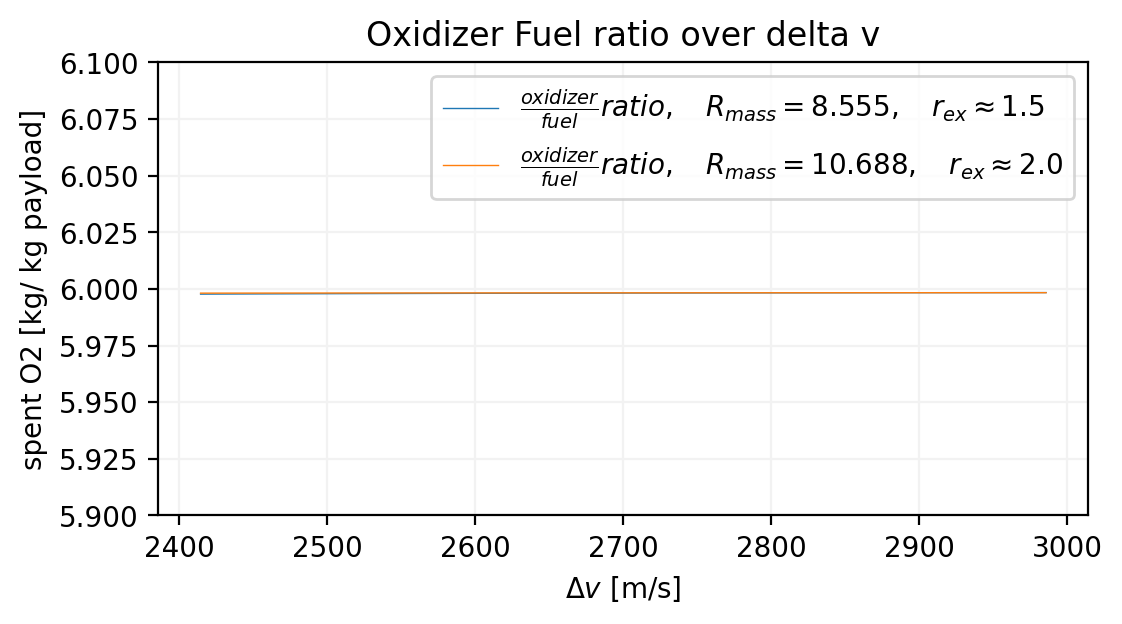

In [73]:
# (v) spent O2
#-------------------------------------------------
# linear fit
m_O2_1_5, n_O2_1_5 = np.polyfit(x, v_1_5, 1)
m_O2_2_5, n_O2_2_5 = np.polyfit(x, v_2_5, 1)
y_O2_pred_1_5 = m_O2_1_5 * x + n_O2_1_5
y_O2_pred_2_5 = m_O2_2_5 * x + n_O2_2_5
print('spent O2')
print(f'f(x)_1.25 = {m_O2_1_5}*x + {n_O2_1_5}')
print(f'f(x)_1.5  = {m_O2_2_5}*x + {n_O2_2_5}')

# (w) spent H2
#-------------------------------------------------
# linear fit
m_H2_1_5, n_H2_1_5 = np.polyfit(x, w_1_5, 1)
m_H2_2_5, n_H2_2_5 = np.polyfit(x, w_2_5, 1)
y_H2_pred_1_5 = m_H2_1_5 * x + n_H2_1_5
y_H2_pred_2_5 = m_H2_2_5 * x + n_H2_2_5
print('spent H2')
print(f'f(x)_1.5 = {m_H2_1_5}*x + {n_H2_1_5}')
print(f'f(x)_2.5 = {m_H2_2_5}*x + {n_H2_2_5}')

plt.figure(figsize=(6,3), dpi=200)

plt.title("Oxidizer Fuel ratio over delta v")
plt.grid(axis='both', color='0.95')


plt.plot(x,(y_O2_pred_1_5/y_H2_pred_1_5),label=r'$\frac{oxidizer}{fuel} ratio, \quad R_{mass}=8.555, \quad r_{ex} \approx 1.5$', linewidth=0.5)
plt.plot(x,(y_O2_pred_2_5/y_H2_pred_2_5),label=r'$\frac{oxidizer}{fuel} ratio, \quad R_{mass}=10.688, \quad r_{ex} \approx 2.0$', linewidth=0.5)


#plt.yscale('log')
plt.ylim(5.9,6.1)
plt.ylabel("spent O2 [kg/ kg payload]")
plt.xlabel("$\Delta v$ [m/s]")
plt.legend()
ax = plt.gca()
#ax.yaxis.set_minor_locator(MultipleLocator(0.02))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.2))
#for i, label in enumerate(ax.xaxis.get_ticklabels()):
#    if i % 5 != 0:
#        label.set_visible(False)
#ax.tick_params(axis='y', which='minor', colors='0.5')
ax.tick_params(axis='x', which='minor', colors='0.5')
plt.savefig('doc\\img\\of_ratio.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
# -> due to constant o/f ratio the constitution of total spent fuel stays constant
# => only save total spent fuel and get O2 and H2 by of_ratio

In [74]:
of_ratio = 6
O2_factor = (of_ratio/(of_ratio+1))
H2_factor = (1/(of_ratio+1))


def spent_total_mapping_1_5(dv):
    #f(x)_1.5 = 0.0000043444*x² + -0.0192068009*x + 23.2144698697
    mass = 0.0000043444 * (dv**2) + -0.0192068009 * dv + 23.2144698697
    return mass

def spent_total_mapping_2_5(dv):
    #f(x)_2.5 = 0.0000024080*x² + -0.0101135316*x + 12.2030160329
    mass = 0.0000024080 * (dv**2) + -0.0101135316 * dv + 12.2030160329
    return mass

def spent_O2_mapping_1_5(dv):
    mass = O2_factor * spent_total_mapping_1_5(dv)
    return mass

def spent_O2_mapping_2_5(dv):
    mass = O2_factor * spent_total_mapping_2_5(dv)
    return mass

def spent_H2_mapping_1_5(dv):
    mass = H2_factor * spent_total_mapping_1_5(dv)
    return mass

def spent_H2_mapping_2_5(dv):
    mass = H2_factor * spent_total_mapping_2_5(dv)
    return mass

In [75]:
# apply aquired function to whole dv map at once
spent_fuel_NRHO_1_5 = spent_total_mapping_1_5(dv_map_NRHO)
spent_fuel_NRHO_2_5 = spent_total_mapping_2_5(dv_map_NRHO)

In [81]:
# save data in xArray to file

Lat, Lon = LatLonfromShape(dv_map_NRHO.shape)

xA_spent_fuel_NRHO_1_5 = xr.DataArray(
    data=spent_fuel_NRHO_1_5,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="spent fuel per kg payload to Lunar Gateway (NRHO) with mass ratio of 8.555 (exchange ratio of 1.5 - 3.30)",
        var_desc="spent fuel",
        units="kg/kg payload",
    ),
)

xA_spent_fuel_NRHO_1_5.to_netcdf("maps/spent_fuel_NRHO_1_5.nc")

In [82]:
# save data in xArray to file

Lat, Lon = LatLonfromShape(dv_map_NRHO.shape)

xA_spent_fuel_NRHO_2_5 = xr.DataArray(
    data=spent_fuel_NRHO_2_5,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="spent fuel per kg payload to Lunar Gateway (NRHO) with mass ratio of 10.688 (exchange ratio of 2.0 - 3.89)",
        var_desc="spent fuel",
        units="kg/kg payload",
    ),
)

xA_spent_fuel_NRHO_2_5.to_netcdf("maps/spent_fuel_NRHO_2_0.nc")

In [7]:
# load xArray
spent_fuel_NRHO_1_5 = xr.open_dataarray("maps/spent_fuel_NRHO_1_5.nc").data
spent_fuel_NRHO_2_5  = xr.open_dataarray("maps/spent_fuel_NRHO_2_0.nc").data

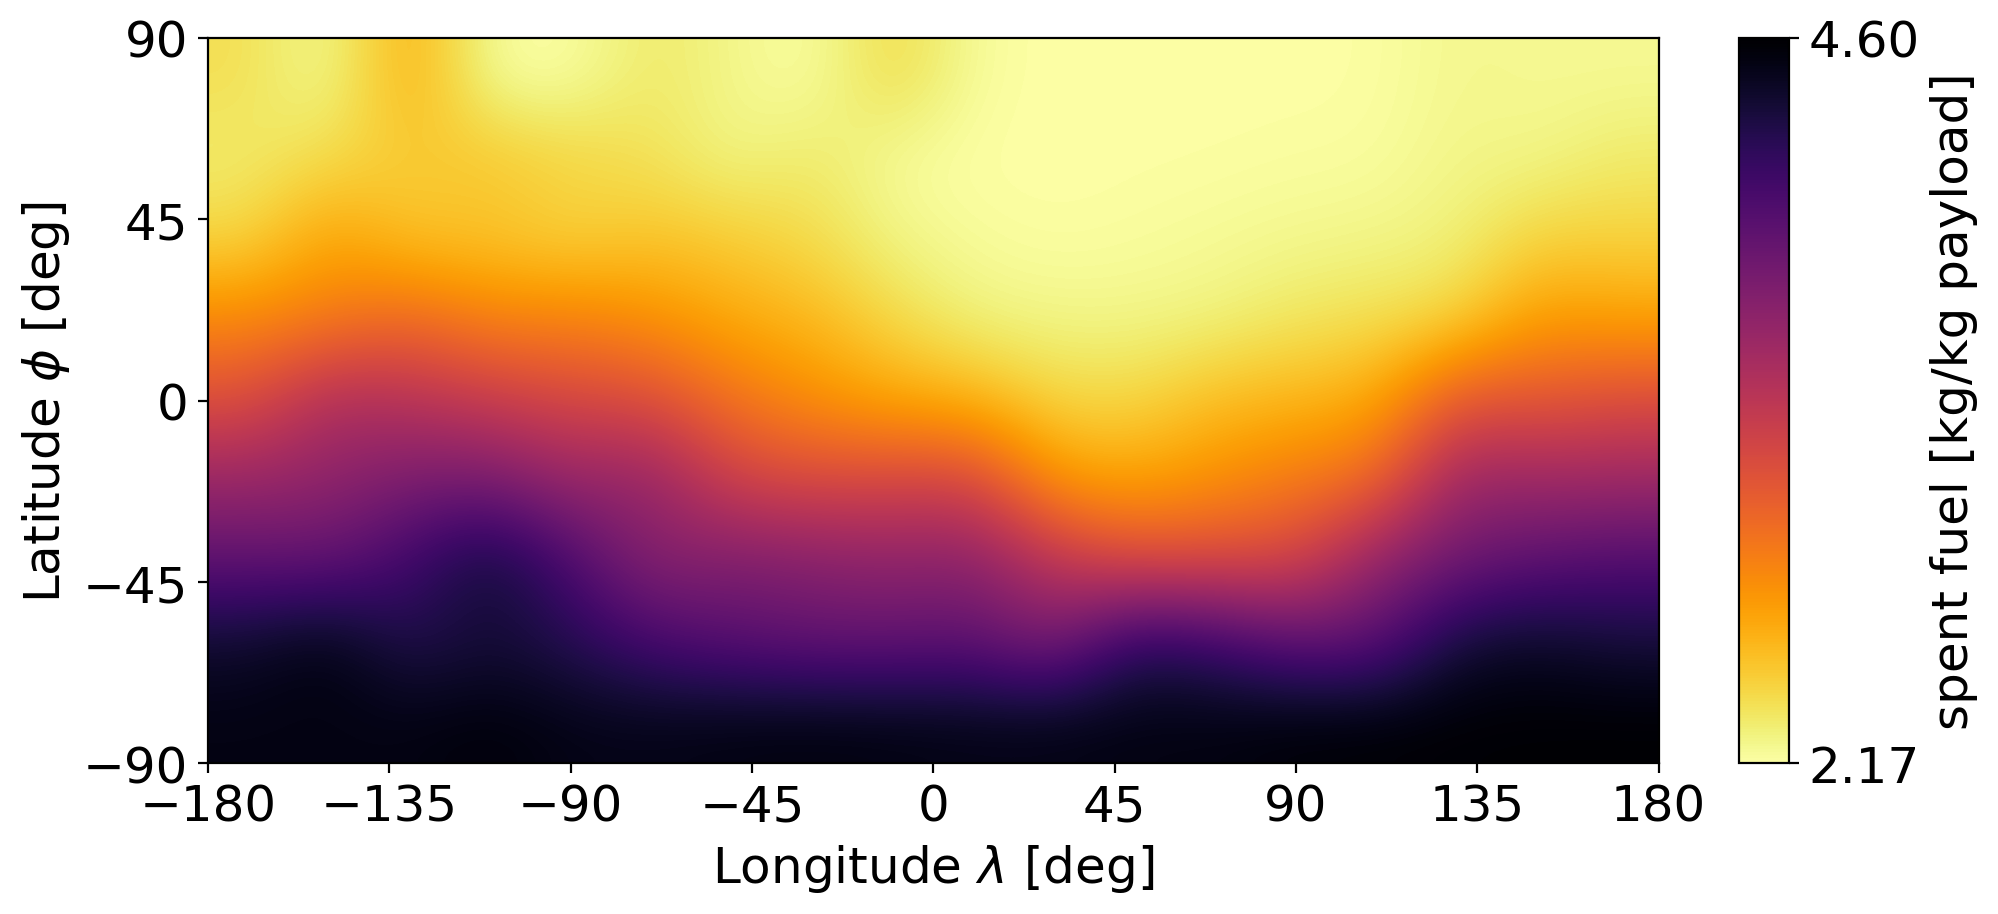

In [10]:
plot_map(spent_fuel_NRHO_1_5,1,'spent fuel [kg/kg payload]',tuple((-90,90)),tuple((-180,180)),i_steps=[],cmap=inferno.reversed(),interpolation='bicubic',silent=True,labelsize=18,save="cost_map_NRHO_1_5.pdf")

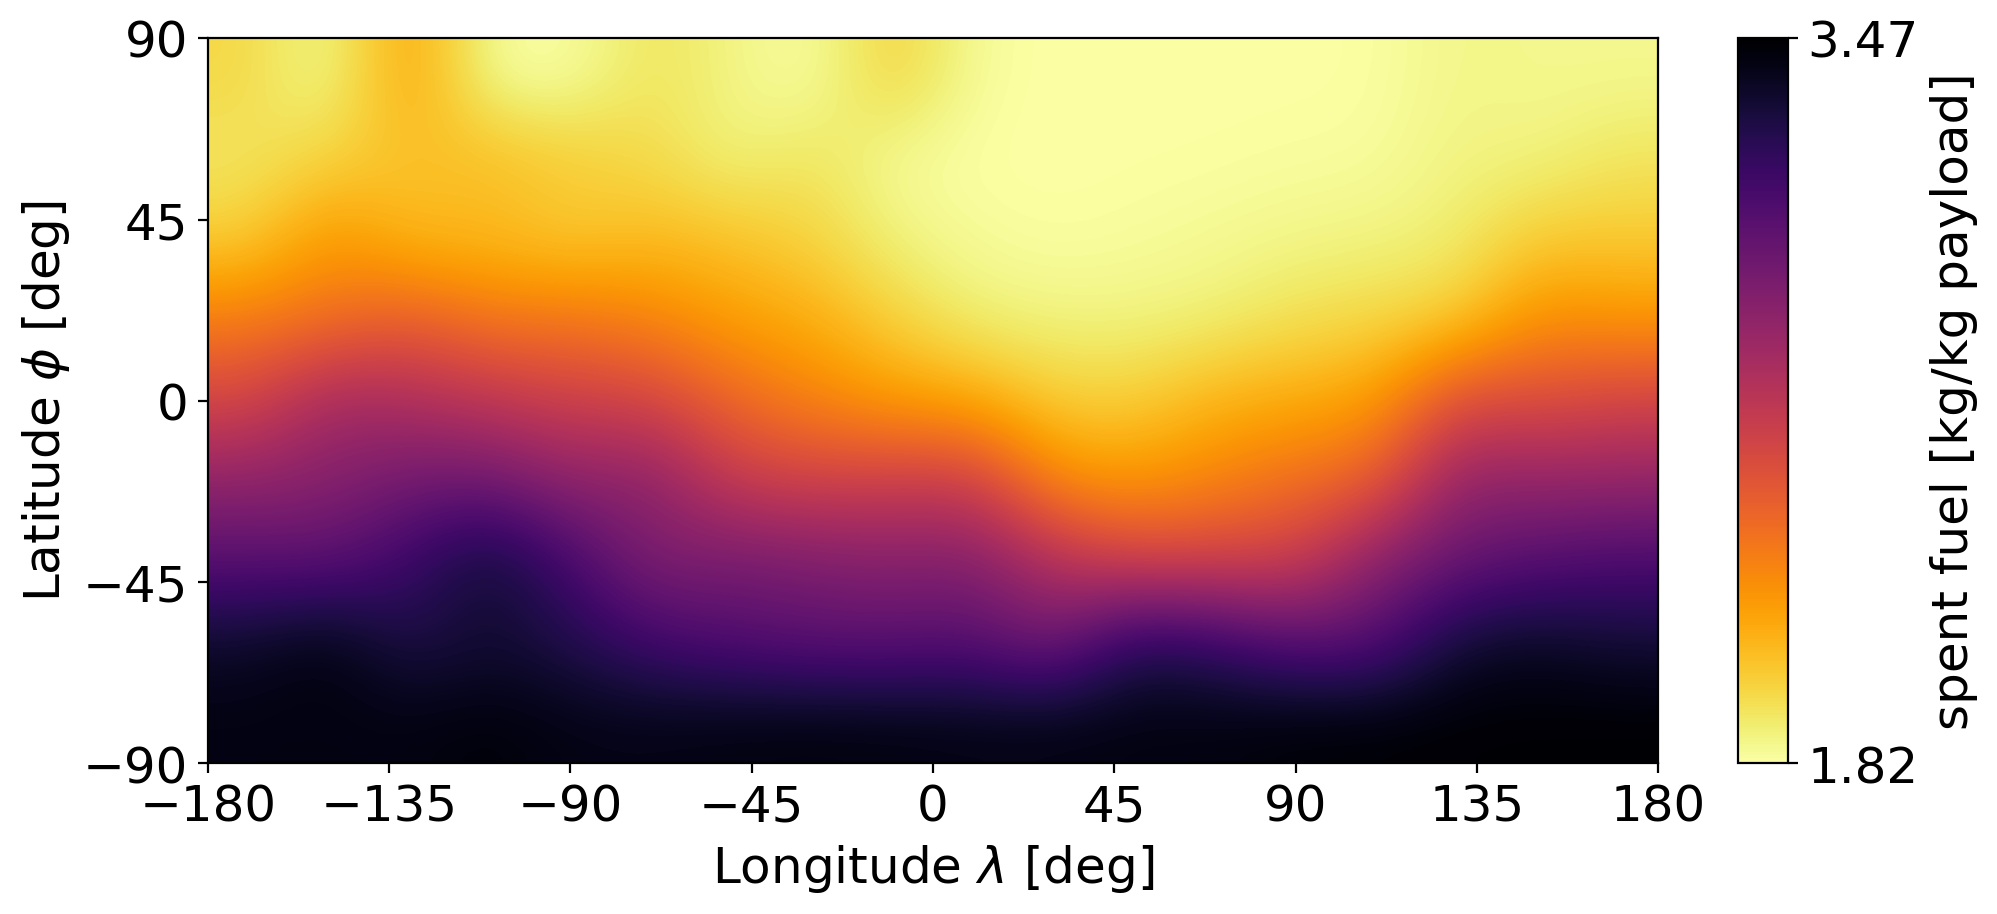

In [11]:
plot_map(spent_fuel_NRHO_2_5,1,'spent fuel [kg/kg payload]',tuple((-90,90)),tuple((-180,180)),i_steps=[],cmap=inferno.reversed(),interpolation='bicubic',silent=True,labelsize=18,save="cost_map_NRHO_2_0.pdf")